# NN2

## Implementacja propagacji wstecznej błędu

W ramach tego laboratorium trzeba zaimplementować uczenie sieci neuronowej propagacją wsteczną błędu. Aby sprawdzić implementację, należy wykonać uczenie na prostych danych do uczenia dostarczonych na zajęciach. Następnie należy zaimplementować metodę wizualizacji wartości wag sieci w kolejnych iteracjach i, w przypadku gdy nie udaje się nauczyć sieci, spróbować wykorzystać te wizualizacje do ustalenia przyczyny problemu. Zaimplementować wersję z aktualizacją wag po prezentacji wszystkich wzorców i wersję z aktualizacją po prezentacji kolejnych porcji (batch). Porównać szybkość uczenia dla każdego z wariantów.

Inicjować wagi z rozkładu jednostajnego na przedziale [0,1]. Opcjonalnie zaimplementować inną metodą inicjowania wag. Albo metodę He albo Xavier.

Przetestować uczenie sieci na następujących zbiorach (w nawiasach wartość MSE, aby otrzymać 4 punkty):

- square-simple (jeśli sieć nie jest w stanie się nauczyć tej funkcji to coś jest bardzo źle zrobione, MSE: 4)
- steps-small (MSE: 4)
- multimodal-large (MSE: 40)

(Wartości MSE liczone na nieznormalizowanych danych)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def linear(x):
    return x

def sigmoid_der(x):
    return x * (1 - x)

def linear_der(x):
    return np.ones((len(x), 1))

class MLP:
    def __init__(self, layer_sizes,
                 hidden_activation='sigmoid',
                 output_activation='linear'):
        self.activation_functions = {
            'sigmoid': sigmoid,
            'linear': linear
        }

        self.activation_functions_der = {
            'sigmoid': sigmoid_der,
            'linear': linear_der
        }
        # output_activation = "sigmoid" - tylko dla danych [0,1]

        self.hidden_activation = self.activation_functions[hidden_activation]
        self.output_activation = self.activation_functions[output_activation]
        self.loss = []
        self.output_activation_der = self.activation_functions_der[output_activation]
        self.hidden_activation_der = self.activation_functions_der[hidden_activation]
        self.weights_history = []
        self.biases_history = []
        self.layer_sizes = layer_sizes
        self.errors = []
        self.gradients = []
        np.random.seed(42)
        self.weights = []
        self.biases = []

        # Inicjalizacja wag z normalizacją (Xavier)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) / np.sqrt(layer_sizes[i])
            b = np.zeros((layer_sizes[i + 1],))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)

        activation = X
        activations = [X]
        for i in range(len(self.weights) - 1):
            weights = self.weights[i]
            biases = self.biases[i]
            Y = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation(Y)
            activations.append(activation)

        Y = activation @ self.weights[-1] + self.biases[-1]
        activation = self.output_activation(Y)
        activations.append(activation)
        return activations

    def predict(self, X):
        return self.forward(X)[-1]

    def set_weights_and_biases(self, layer_idx, W, b):
        self.weights[layer_idx] = W
        self.biases[layer_idx] = b

    def mse(self, y_true, y_pred):
        diff = y_true - y_pred
        diff = np.clip(diff, -1e150, 1e150)  
        return np.mean((diff) ** 2)

    def backpropagate(self, X, y_true, activations):
        output = activations[-1]
        error = output - y_true
        self.errors.append(np.mean(np.square(error)))

        delta = error * self.output_activation_der(output)
        deltas = [delta]

        for i in range(len(self.weights) - 2, -1, -1):
            delta = deltas[-1] @ self.weights[i + 1].T * self.hidden_activation_der(activations[i + 1])
            deltas.append(delta)

        deltas.reverse()
        return deltas

    def update_weights_and_biases(self, activations, deltas, learning_rate):
        for i in range(len(self.weights)):
            activation = activations[i]
            delta = deltas[i]
            self.weights[i] -= learning_rate * activation.T @ delta
            self.biases[i] -= learning_rate * np.sum(delta, axis=0)

    def fit(self, X, y, epochs=1000, learning_rate=0.01, MSE=3):
        m = X.shape[0]
        for epoch in range(epochs):
            activations = self.forward(X)
            
            loss = self.mse(y, activations[-1])
            self.loss.append(loss)
            self.errors.append(loss)
            
            if loss < MSE :
                print("finished_early on epoch: ", epoch, ", with MSE = ", loss)
                plt.plot(self.loss)
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training Loss')
                plt.show()
                return
            deltas = self.backpropagate(X, y, activations)
            self.update_weights_and_biases(activations, deltas, learning_rate)
            self.weights_history.append([w.copy() for w in self.weights])
            self.biases_history.append([w.copy() for w in self.biases])

            if (epoch) % 1000 == 0:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss}')
        plt.plot(self.loss)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()


    def visualize_weights(self, layer_idx):

        if not self.weights_history:
            print("Brak danych o wagach. Uruchom najpierw metodę fit().")
            return

        weights_for_layer = np.array([weights[layer_idx] for weights in self.weights_history])

        plt.figure(figsize=(12, 6))
        for i in range(weights_for_layer.shape[1]):
            for j in range(weights_for_layer.shape[2]):
                plt.plot(weights_for_layer[:, i, j], label=f'Neuron {i}-{j}')

        plt.xlabel("Epoch")
        plt.ylabel("Weight Value")
        plt.title(f"Weight Changes for Layer {layer_idx} Over Epochs")
        plt.legend(loc='upper right', fontsize=8)
        plt.tight_layout()
        plt.show()

    def visualize_biases(self, layer_idx):
        if not self.weights_history:
            print("Brak danych o biasach. Uruchom najpierw metodę fit().")
            return

        biases_for_layer = np.array([bias[layer_idx] for bias in self.biases_history])

        if biases_for_layer.ndim == 1:
            plt.plot(biases_for_layer, label=f"Bias w warstwie {layer_idx}", color='red')
        else:
            plt.figure(figsize=(12, 6))
            for i in range(biases_for_layer.shape[1]):
                plt.plot(biases_for_layer[:, i], label=f'Bias {i} w warstwie {layer_idx}')

        plt.xlabel("Epoki")
        plt.ylabel("Wartość biasu")
        plt.title(f"Wartości biasów dla warstwy {layer_idx} w trakcie treningu")
        plt.legend()
        plt.tight_layout()
        plt.show()


    def fit_batch(self, X, y, epochs=1000, learning_rate=0.01, MSE = 3, batch_size=32):
        m = X.shape[0]
        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            for start_idx in range(0, m, batch_size):
                end_idx = min(start_idx + batch_size, m)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                activations = self.forward(X_batch)
                deltas = self.backpropagate(X_batch, y_batch, activations)
                self.update_weights_and_biases(activations, deltas, learning_rate)
            loss = self.mse(y, self.predict(X))
            self.loss.append(loss)
            self.errors.append(loss)
            
            self.weights_history.append([w.copy() for w in self.weights])
            self.biases_history.append([b.copy() for b in self.biases])
            if loss < MSE :
                print("finished_early on epoch: ", epoch, ", with MSE = ", loss)
                plt.plot(self.loss)
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training Loss')
                plt.show()
                return

            if (epoch + 1) % 1000 == 0:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss}')
        plt.plot(self.loss)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()


## 1. Steps small

### Uczenie na całym zbiorze

Epoch 1/50000000, Loss: 6654.835743388886
Epoch 1001/50000000, Loss: 1434.4972459432527
Epoch 2001/50000000, Loss: 381.13421984698545
Epoch 3001/50000000, Loss: 124.96375504850565
Epoch 4001/50000000, Loss: 63.26375357129914
Epoch 5001/50000000, Loss: 30.390711426604962
Epoch 6001/50000000, Loss: 15.428966439406752
Epoch 7001/50000000, Loss: 10.405506105599638
Epoch 8001/50000000, Loss: 8.168449915499213
Epoch 9001/50000000, Loss: 6.857796630481633
Epoch 10001/50000000, Loss: 5.970833889749824
Epoch 11001/50000000, Loss: 5.321780889166211
Epoch 12001/50000000, Loss: 4.8225424664827266
Epoch 13001/50000000, Loss: 4.42435400502909
Epoch 14001/50000000, Loss: 4.097762877241721
Epoch 15001/50000000, Loss: 3.823889003239985
Epoch 16001/50000000, Loss: 3.5900522840300018
Epoch 17001/50000000, Loss: 3.387405943030304
Epoch 18001/50000000, Loss: 3.2095785294016843
Epoch 19001/50000000, Loss: 3.0518562568322447
Epoch 20001/50000000, Loss: 2.9106701883554575
Epoch 21001/50000000, Loss: 2.7832631

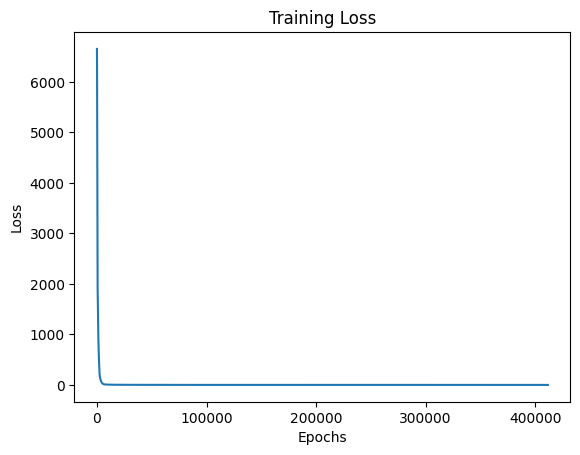

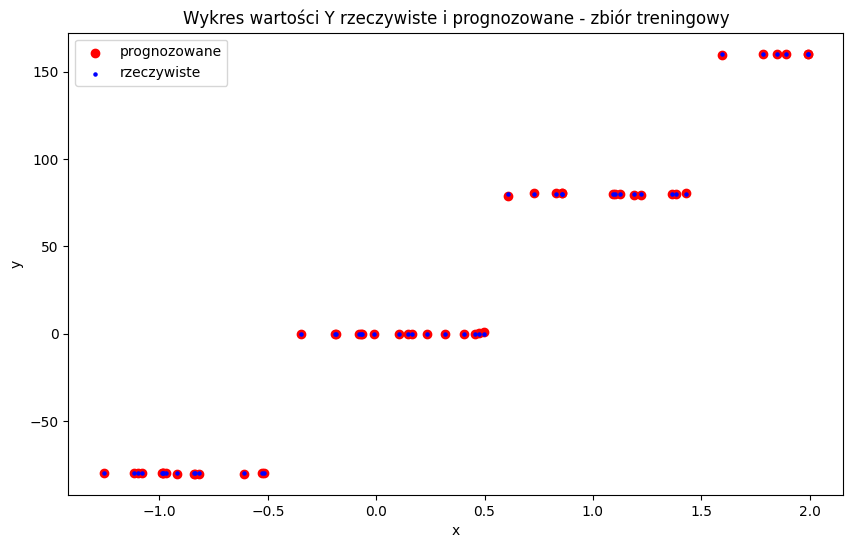

Train MSE =  0.0999999070265948
 Test MSE =  45.6698366521259


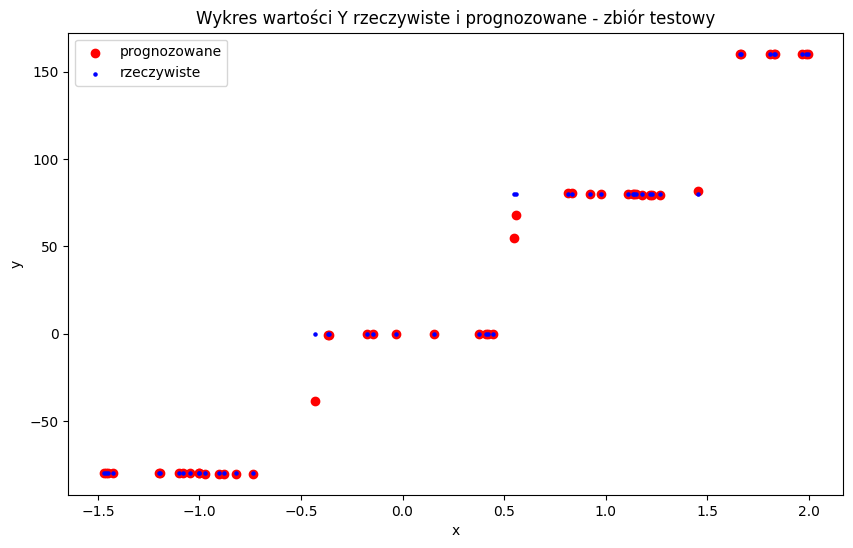

C:\Users\okroj\AppData\Local\Temp\ipykernel_27224\2762737853.py:175: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\okroj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


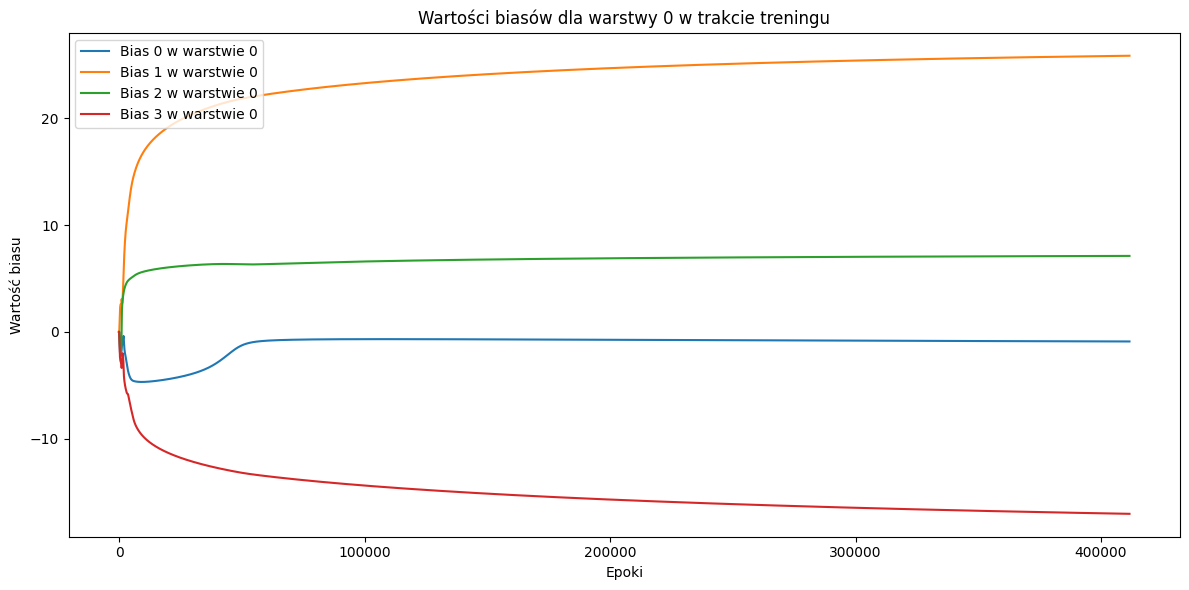

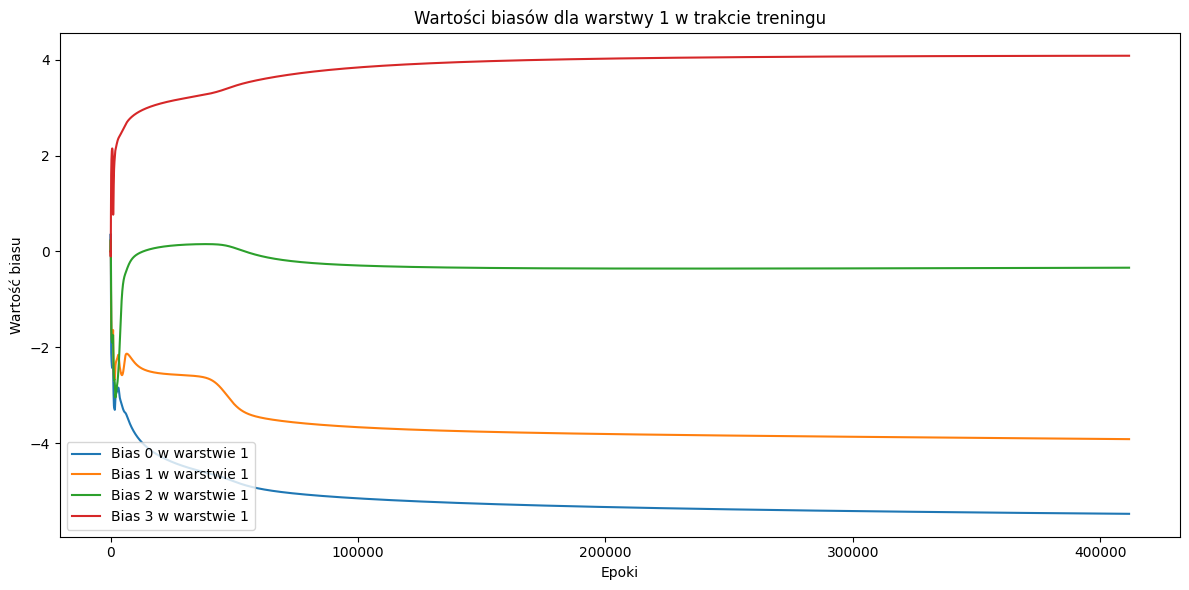

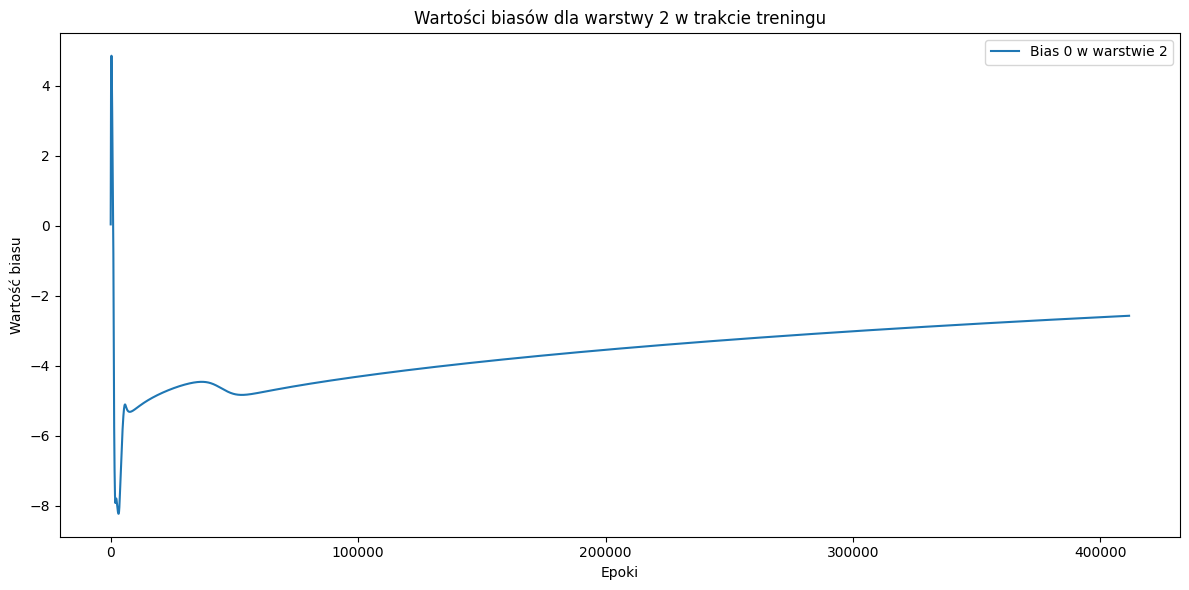

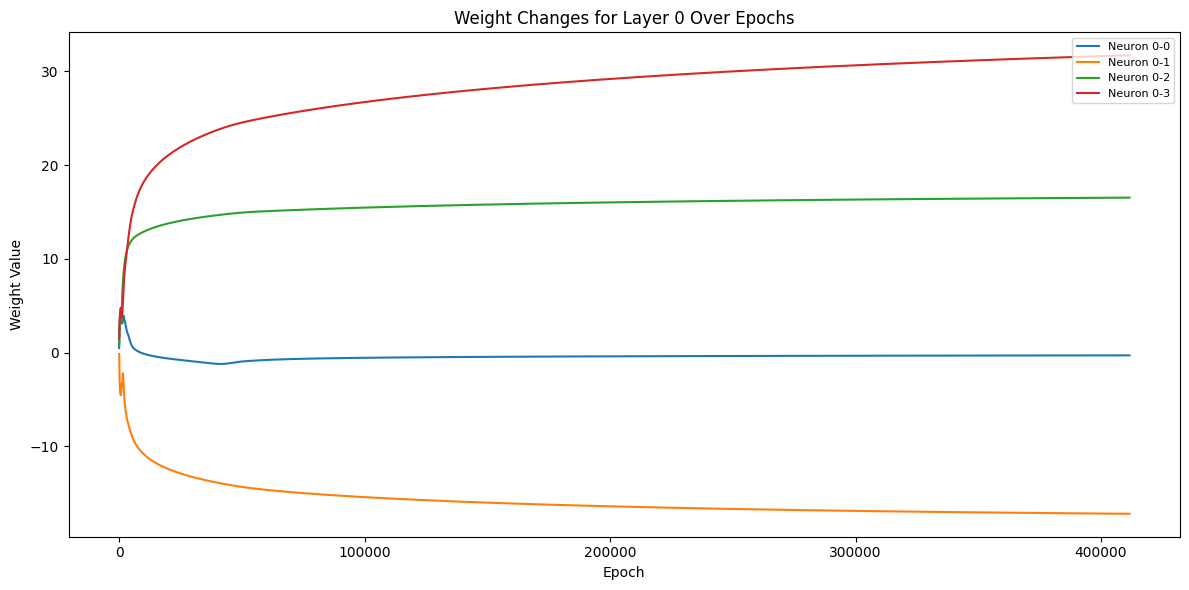

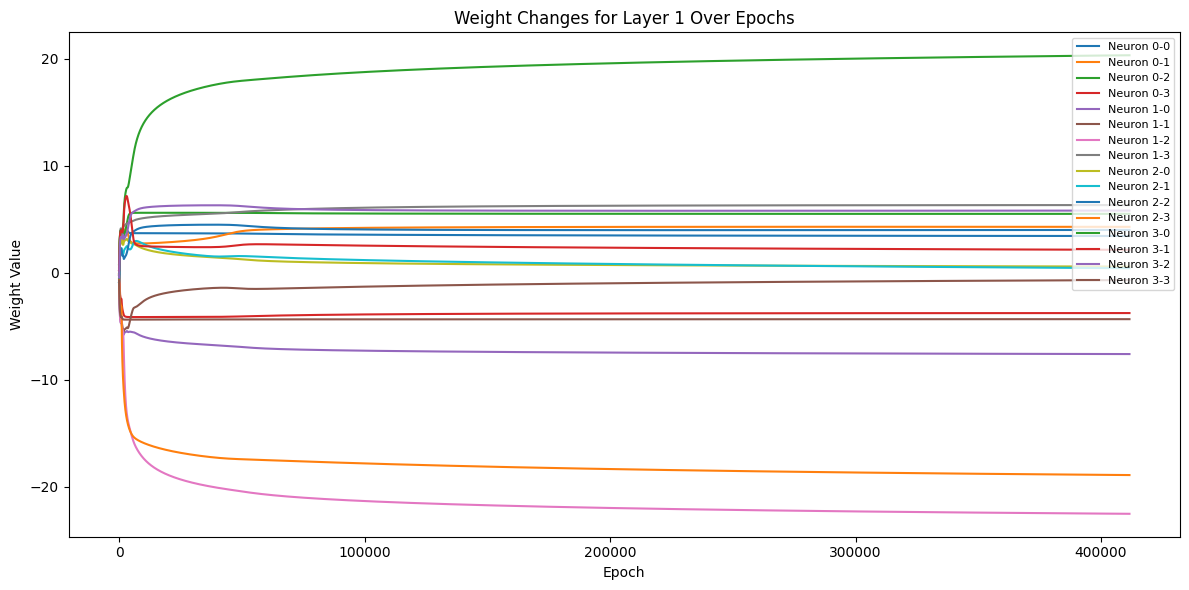

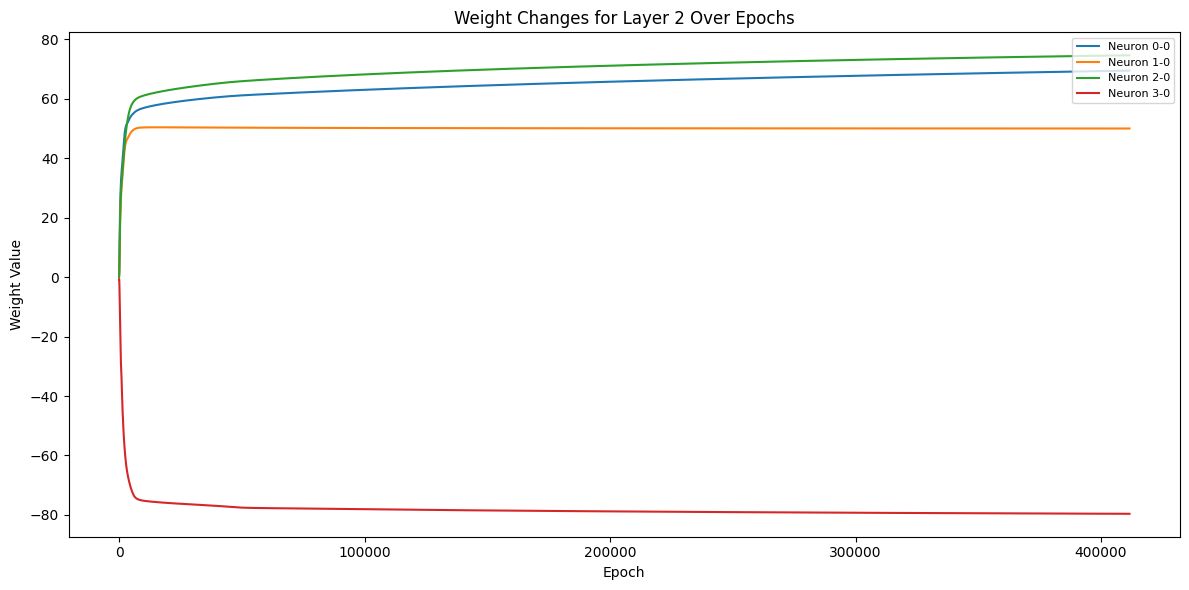

In [21]:

mlp = MLP([1, 4,4, 1])
df = pd.read_csv('mio1/regression/steps-small-training.csv', index_col=0)
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)
df = pd.read_csv('mio1/regression/steps-small-test.csv', index_col=0)
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)




mlp.fit(X, y_true,50000000, 0.00005, 0.1)

y_pred = mlp.predict(X)
mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)


y_pred = mlp.predict(X_test)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

mlp.visualize_biases(0)
mlp.visualize_biases(1)
mlp.visualize_biases(2)
mlp.visualize_weights(0)
mlp.visualize_weights(1)
mlp.visualize_weights(2)


### Uczenie na kolejnych porcjach danych (batch)

Epoch 1000/50000000, Loss: 1437.7286067214636
Epoch 2000/50000000, Loss: 378.741790275564
Epoch 3000/50000000, Loss: 124.56519309415795
Epoch 4000/50000000, Loss: 63.80165196652919
Epoch 5000/50000000, Loss: 30.484823121974863
Epoch 6000/50000000, Loss: 15.330701143664918
Epoch 7000/50000000, Loss: 10.339985826419525
Epoch 8000/50000000, Loss: 8.102855806266945
Epoch 9000/50000000, Loss: 6.800764055667696
Epoch 10000/50000000, Loss: 5.9187953043933055
Epoch 11000/50000000, Loss: 5.278681517724217
Epoch 12000/50000000, Loss: 4.783152187358012
Epoch 13000/50000000, Loss: 4.389837016999206
Epoch 14000/50000000, Loss: 4.067550027298077
Epoch 15000/50000000, Loss: 3.797615112403994
Epoch 16000/50000000, Loss: 3.5675615721187057
Epoch 17000/50000000, Loss: 3.3677860503564743
Epoch 18000/50000000, Loss: 3.1928269639562443
Epoch 19000/50000000, Loss: 3.0388644426941
Epoch 20000/50000000, Loss: 2.900157170530981
Epoch 21000/50000000, Loss: 2.775039813711394
Epoch 22000/50000000, Loss: 2.6615302

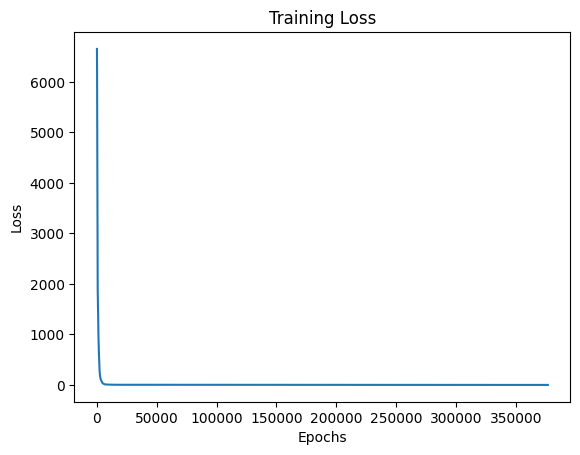

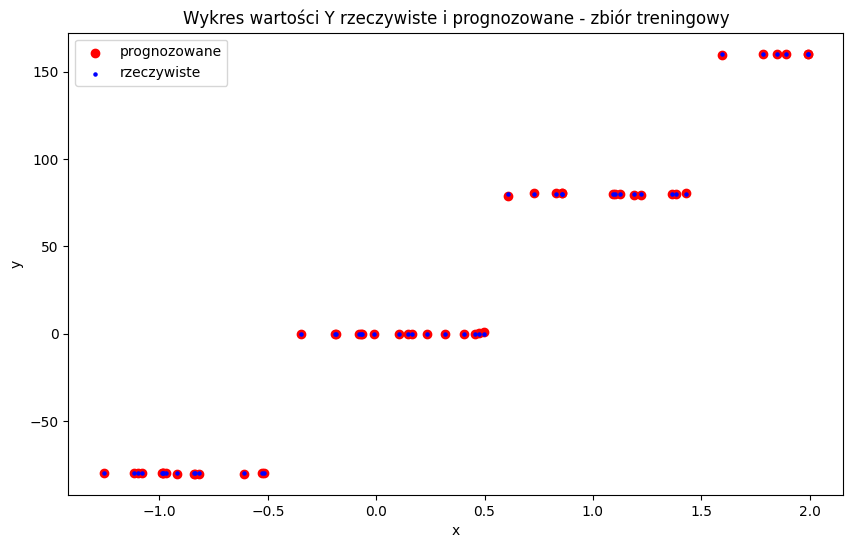

Train MSE =  0.09999932742259525
 Test MSE =  44.697608139194614


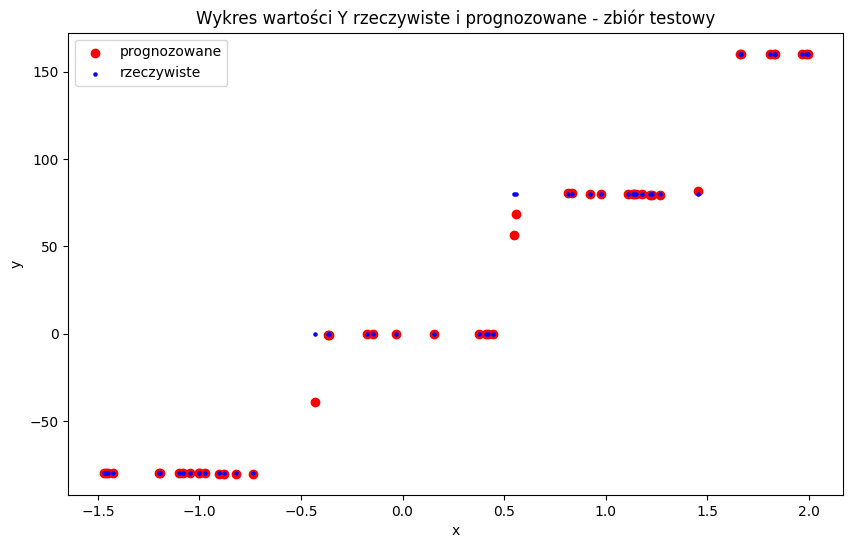

C:\Users\okroj\AppData\Local\Temp\ipykernel_27224\2762737853.py:175: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\okroj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


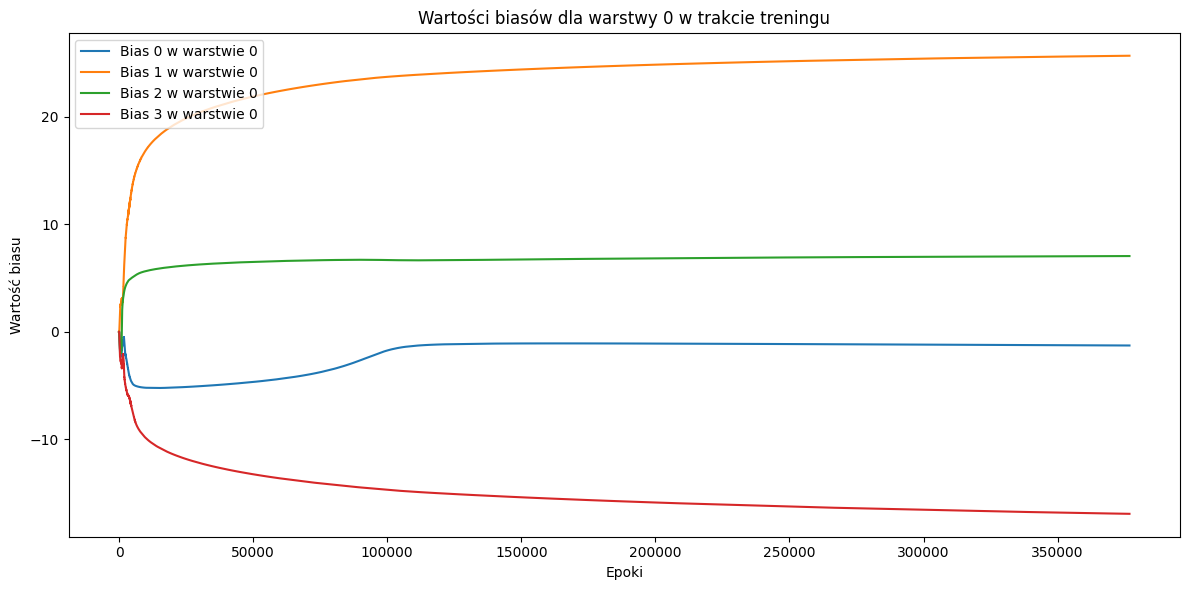

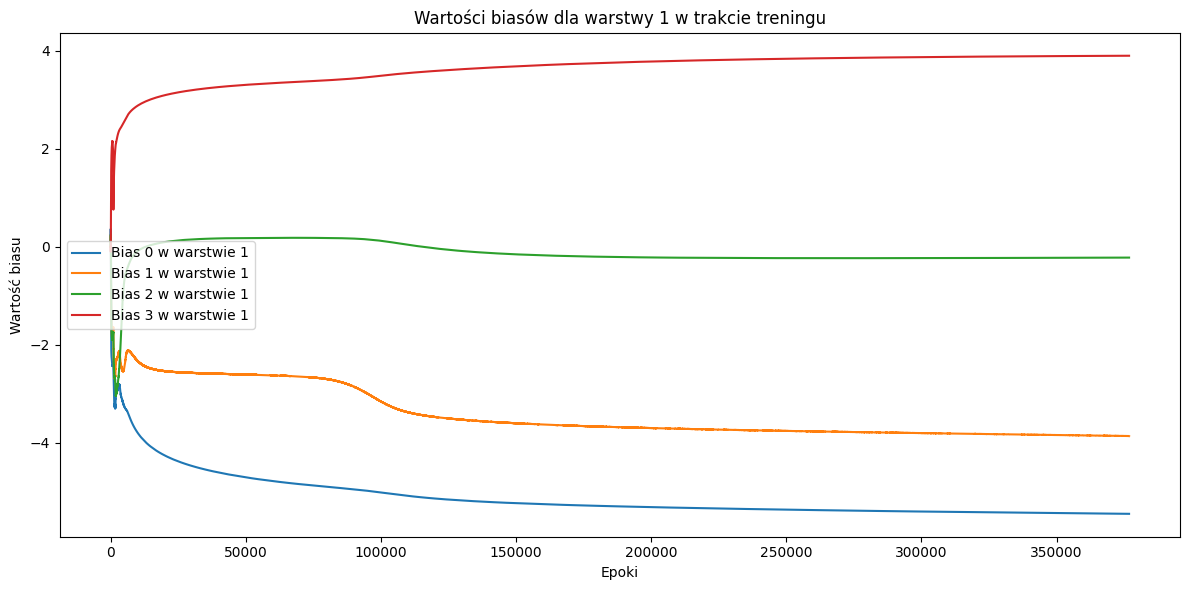

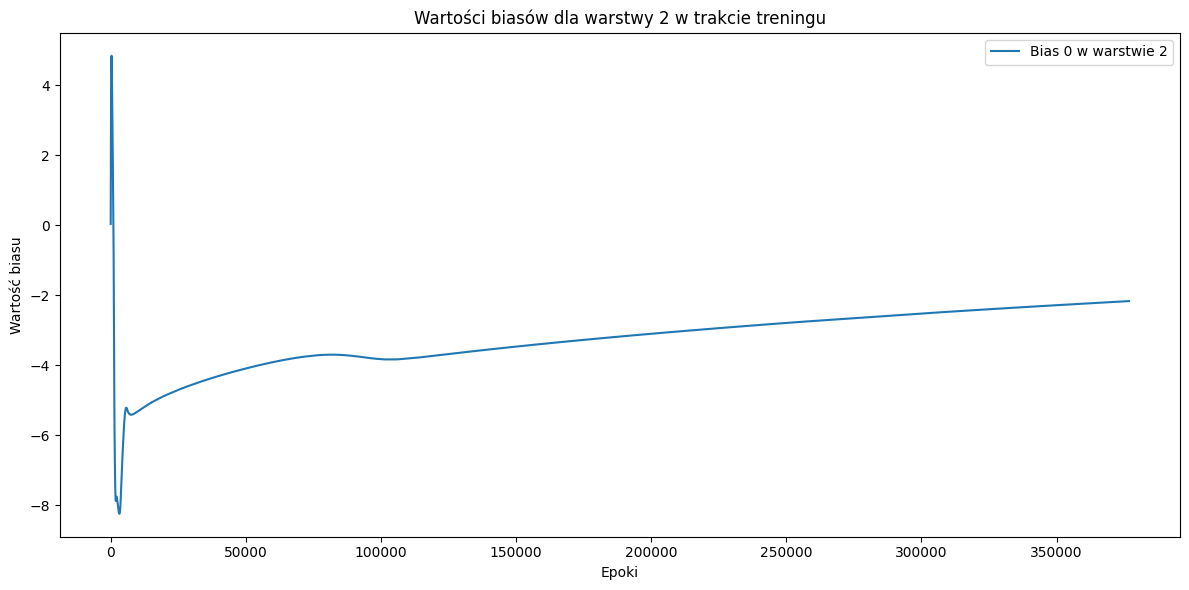

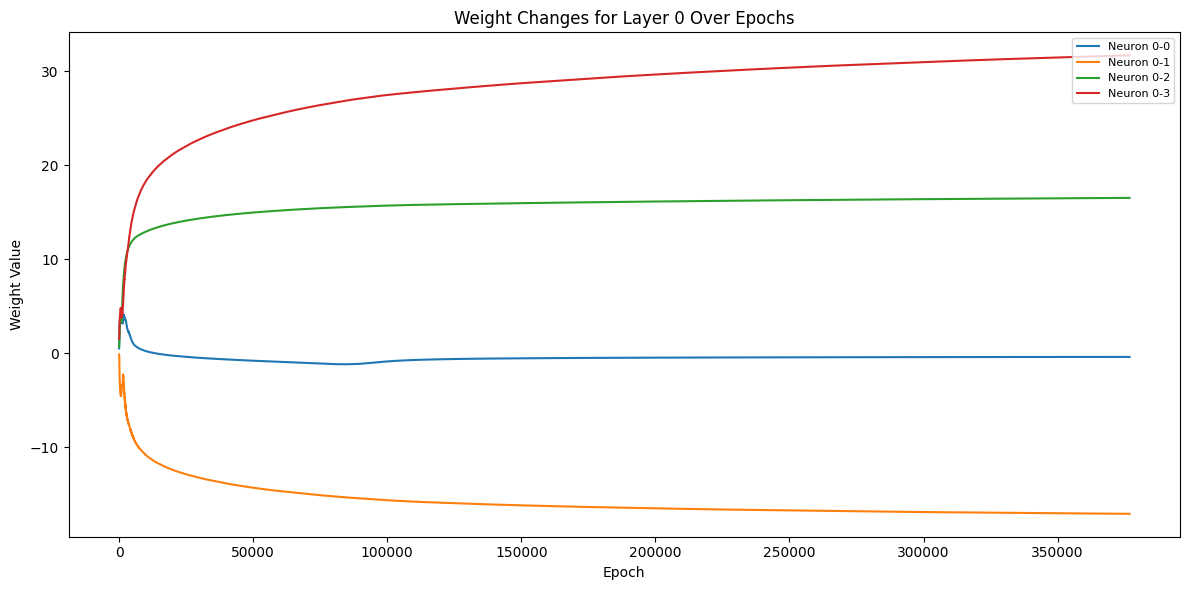

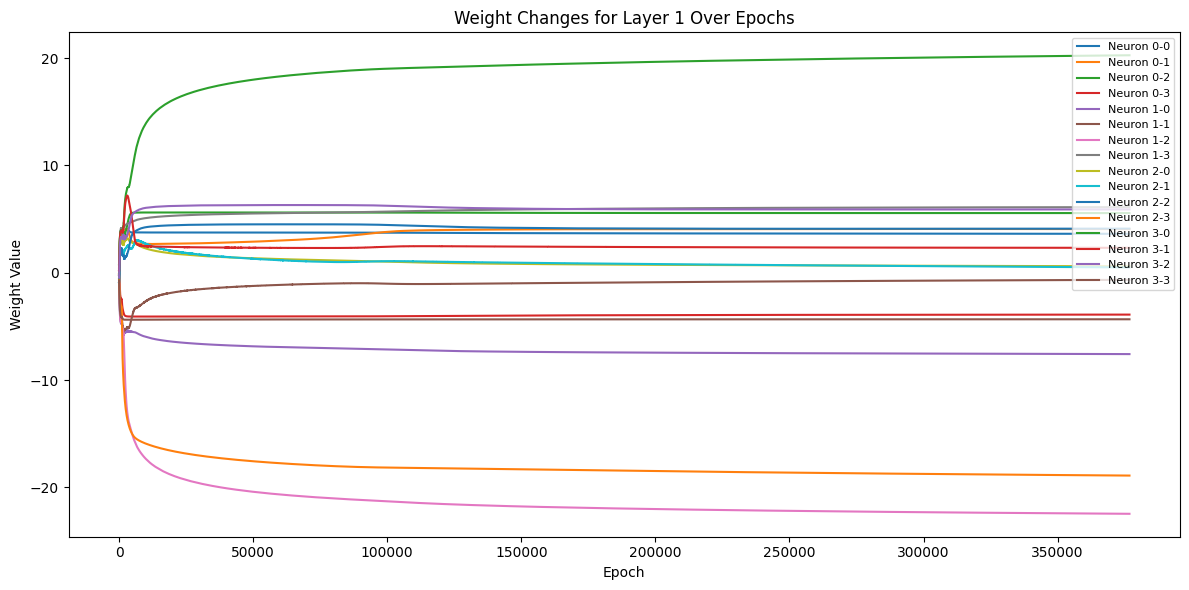

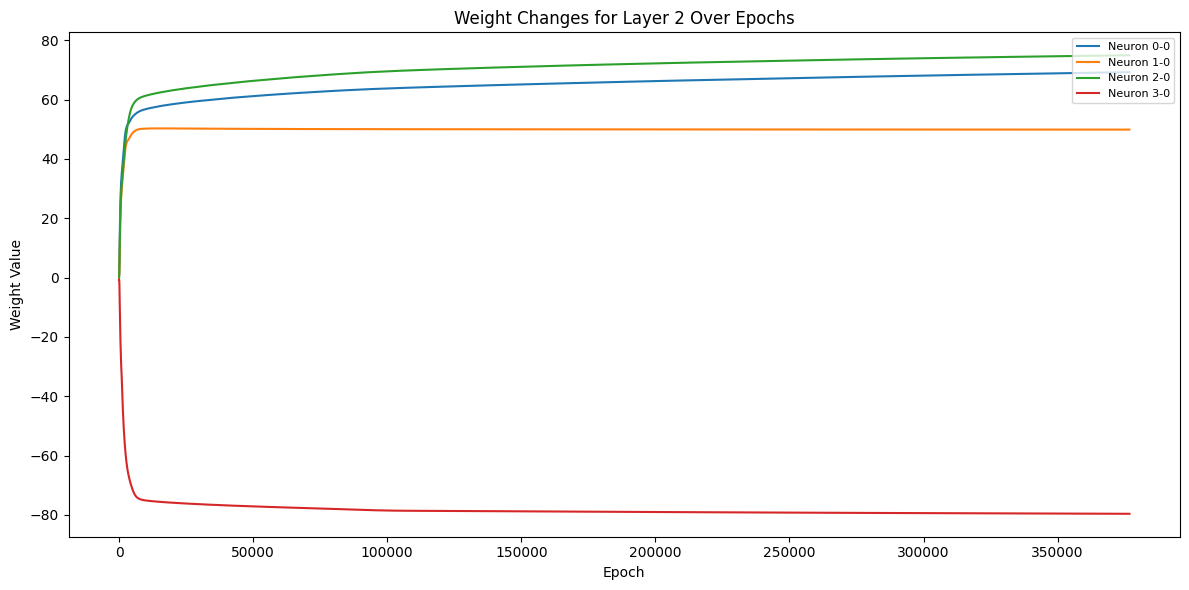

In [22]:

mlp = MLP([1, 4,4, 1])
df = pd.read_csv('mio1/regression/steps-small-training.csv', index_col=0)
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)
df = pd.read_csv('mio1/regression/steps-small-test.csv', index_col=0)
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)




mlp.fit_batch(X, y_true,50000000, 0.00005, 0.1)

y_pred = mlp.predict(X)
mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)


y_pred = mlp.predict(X_test)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

mlp.visualize_biases(0)
mlp.visualize_biases(1)
mlp.visualize_biases(2)
mlp.visualize_weights(0)
mlp.visualize_weights(1)
mlp.visualize_weights(2)


#### Różnica w tempie uczenia:
* całość - epoka:  411 581, MSE =  0.0999999070265948
* batch - epoka: 376 814, MSE =  0.09999932742259525

## 2. Zbiór steps-large 

### Uczenie na całym zbiorze

Epoch 1/500000, Loss: 7370.550535993212
Epoch 1001/500000, Loss: 56.97598894485044
Epoch 2001/500000, Loss: 49.471015493953836
Epoch 3001/500000, Loss: 39.88163685838803
Epoch 4001/500000, Loss: 34.272470719229815
Epoch 5001/500000, Loss: 30.255585356940056
Epoch 6001/500000, Loss: 27.29394413117845
Epoch 7001/500000, Loss: 25.107433097478143
Epoch 8001/500000, Loss: 23.44528507776929
Epoch 9001/500000, Loss: 22.13270377059874
Epoch 10001/500000, Loss: 21.060621787025628
Epoch 11001/500000, Loss: 20.160640770200903
Epoch 12001/500000, Loss: 19.38834987954573
Epoch 13001/500000, Loss: 18.71379475729615
Epoch 14001/500000, Loss: 18.11603165083668
Epoch 15001/500000, Loss: 17.579931582560995
Epoch 16001/500000, Loss: 17.094248573885444
Epoch 17001/500000, Loss: 16.6504161289986
Epoch 18001/500000, Loss: 16.241773795346695
Epoch 19001/500000, Loss: 15.863054304202283
Epoch 20001/500000, Loss: 15.510032987570384
Epoch 21001/500000, Loss: 15.179281217392747
Epoch 22001/500000, Loss: 14.86798

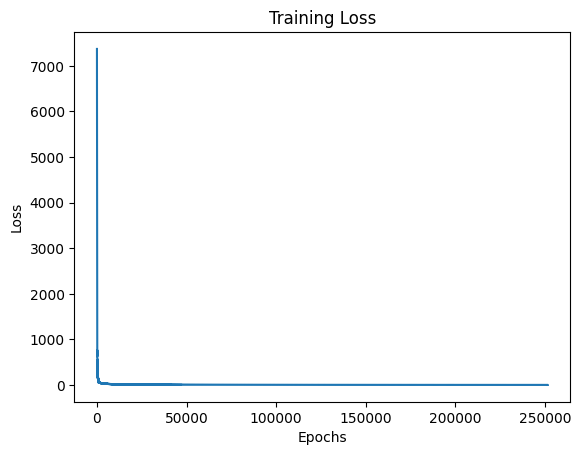

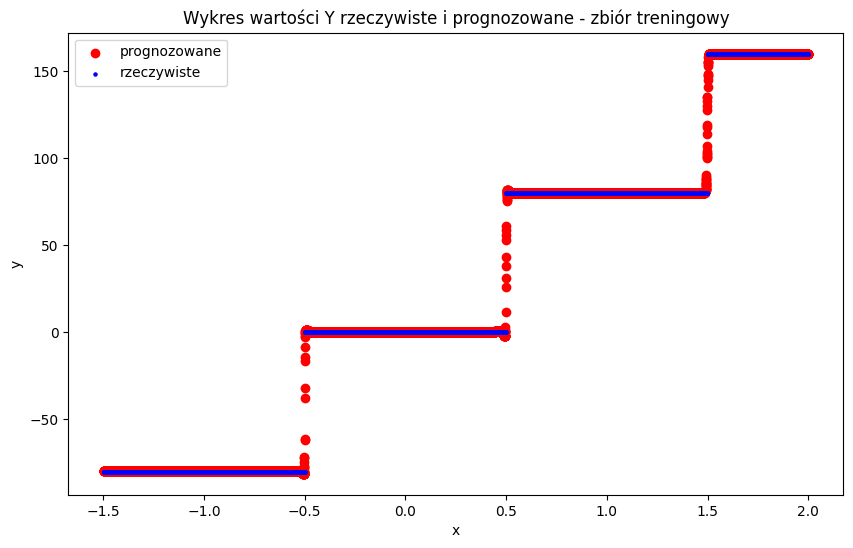

Train MSE =  3.4999911495661187
 Test MSE =  2.471718573203856


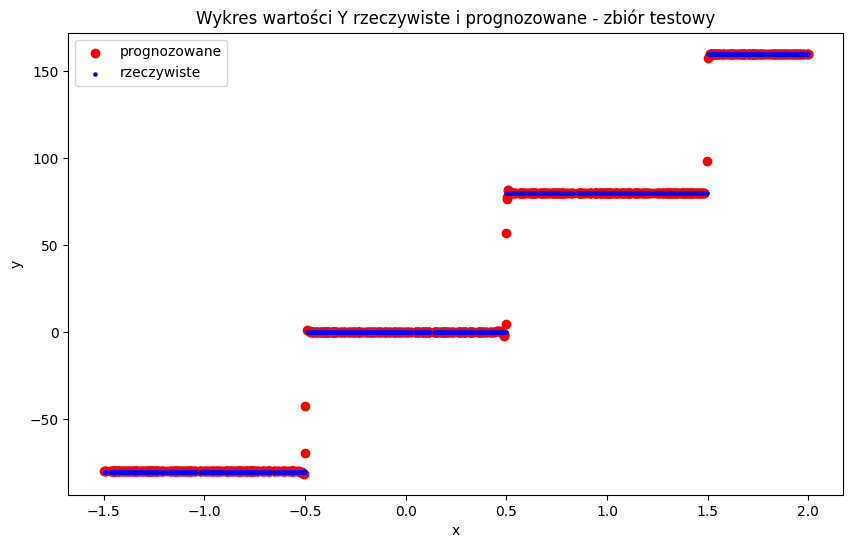

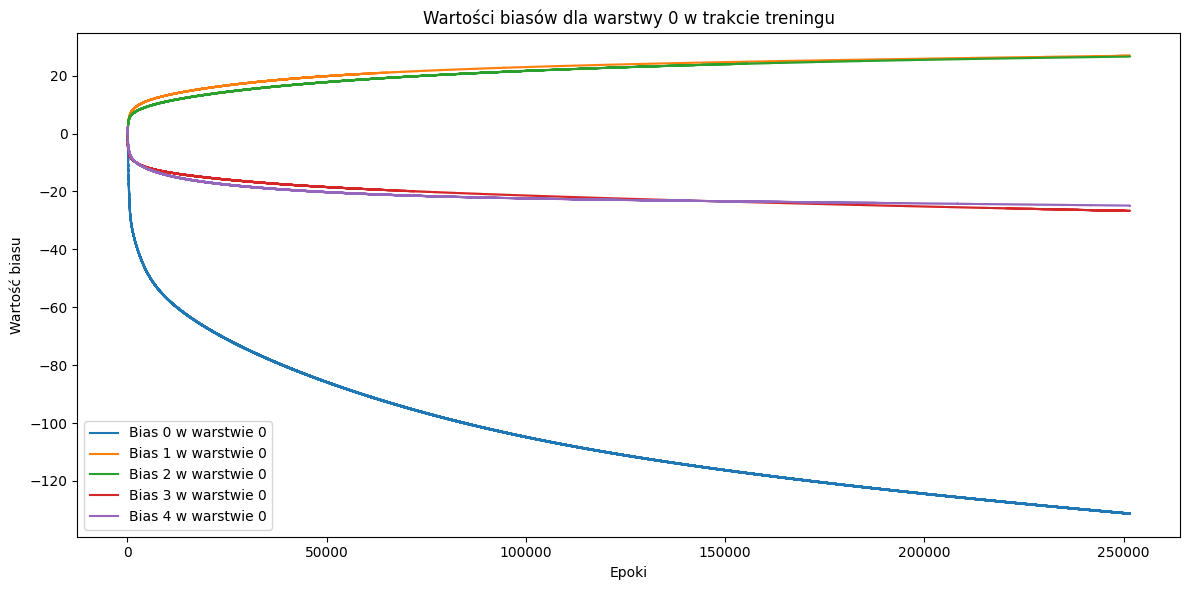

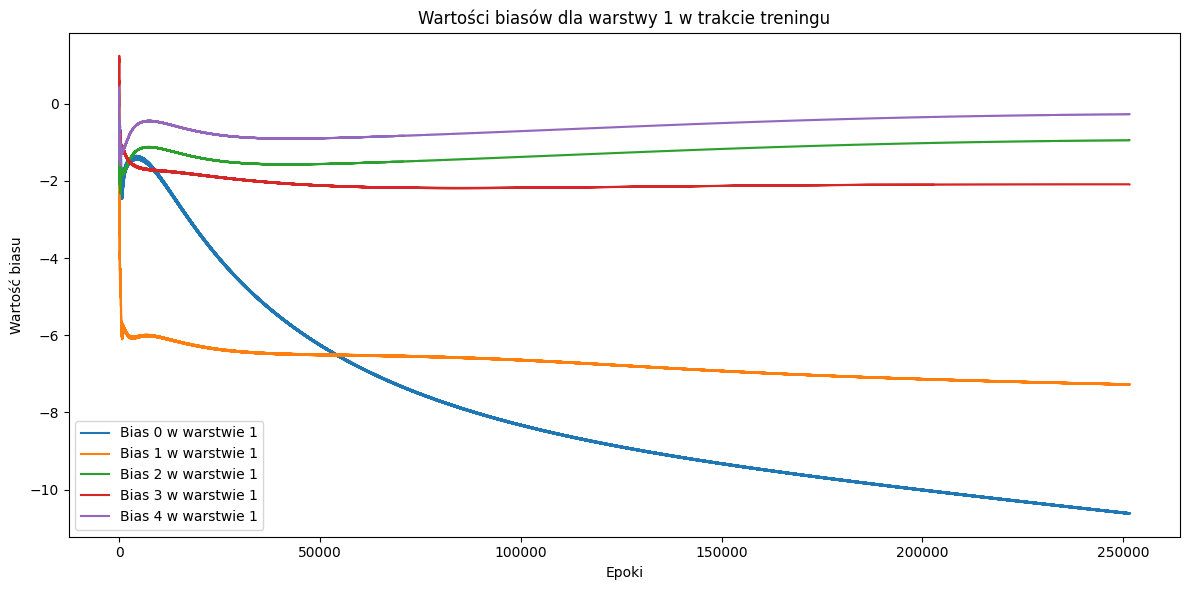

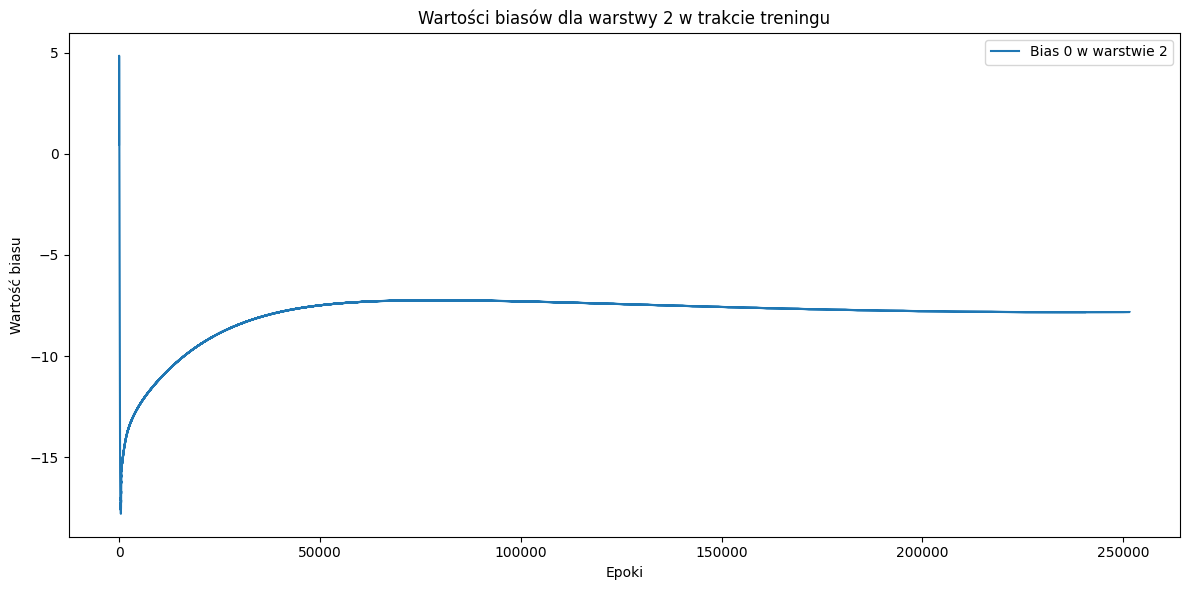

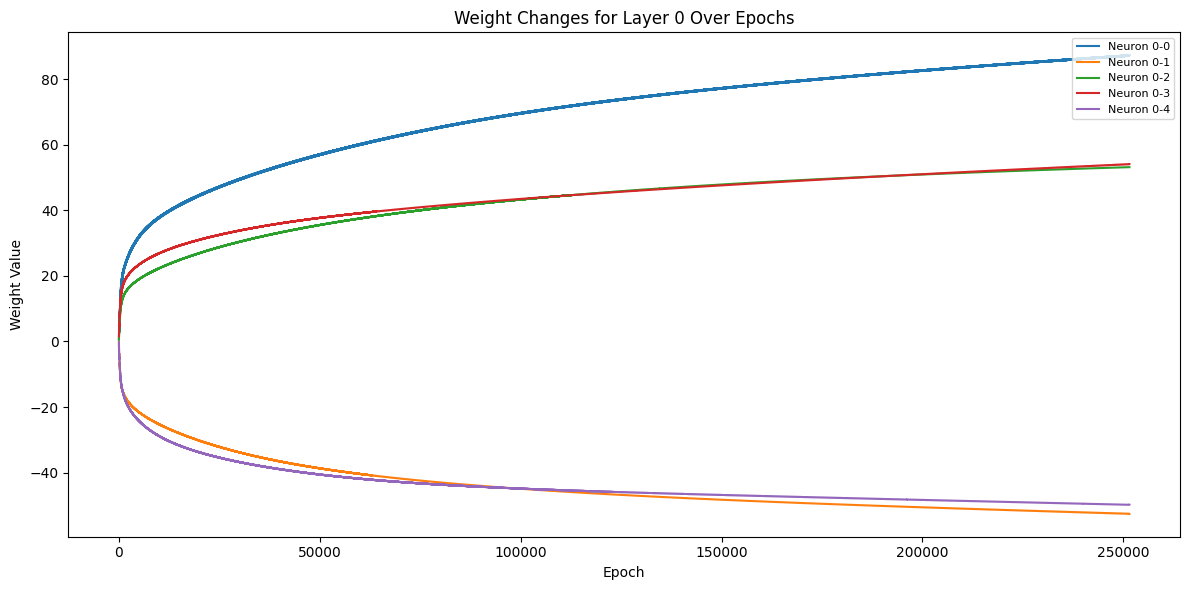

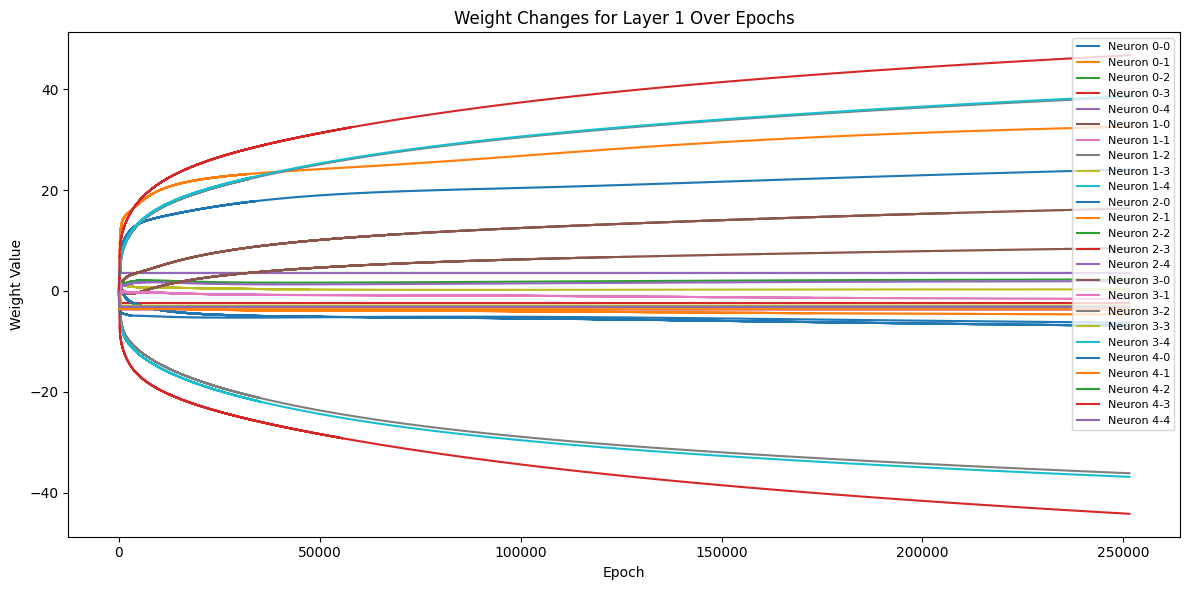

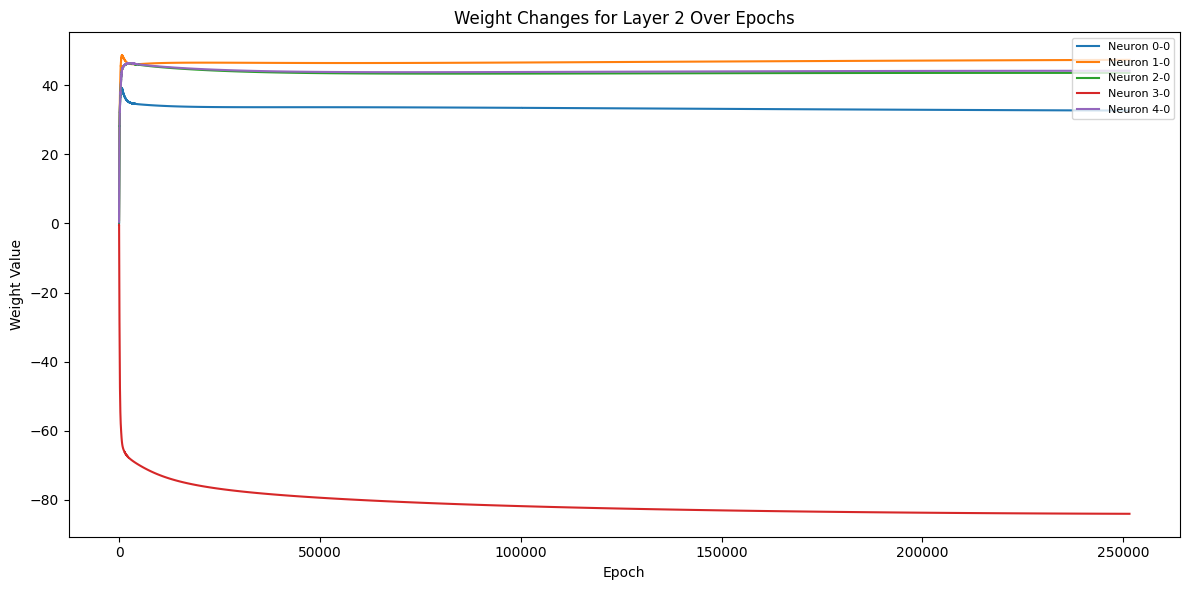

In [44]:
mlp = MLP([1, 5,5, 1])
df = pd.read_csv('mio1/regression/steps-large-training.csv', index_col=0)
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

mlp.fit(X, y_true,500000, 0.000002, 3.5)

y_pred = mlp.predict(X)
mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

df = pd.read_csv('mio1/regression/steps-large-test.csv', index_col=0)
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
y_pred = mlp.predict(X_test)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

mlp.visualize_biases(0)
mlp.visualize_biases(1)
mlp.visualize_biases(2)
mlp.visualize_weights(0)
mlp.visualize_weights(1)
mlp.visualize_weights(2)


### Uczenie na kolejnych porcjach danych (batch)

Epoch 1000/500000, Loss: 41.03614183745991
Epoch 2000/500000, Loss: 28.379775847506103
Epoch 3000/500000, Loss: 23.01476606127287
Epoch 4000/500000, Loss: 19.77984273161992
Epoch 5000/500000, Loss: 17.76159476789066
Epoch 6000/500000, Loss: 15.746191327356696
Epoch 7000/500000, Loss: 14.552284997478546
Epoch 8000/500000, Loss: 13.688416275079229
Epoch 9000/500000, Loss: 12.592562700916757
Epoch 10000/500000, Loss: 13.105255829088415
Epoch 11000/500000, Loss: 11.293672930447855
Epoch 12000/500000, Loss: 10.75581259573762
Epoch 13000/500000, Loss: 10.481966673183923
Epoch 14000/500000, Loss: 9.867545376268398
Epoch 15000/500000, Loss: 9.49267139696931
Epoch 16000/500000, Loss: 9.144347283216849
Epoch 17000/500000, Loss: 8.812555620631409
Epoch 18000/500000, Loss: 8.691508113443165
Epoch 19000/500000, Loss: 8.295474664621024
Epoch 20000/500000, Loss: 8.383405990581204
Epoch 21000/500000, Loss: 7.849069570803536
Epoch 22000/500000, Loss: 7.612705505451345
Epoch 23000/500000, Loss: 7.636099

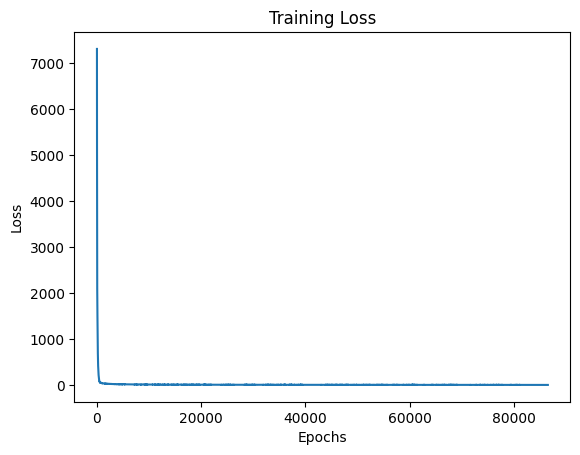

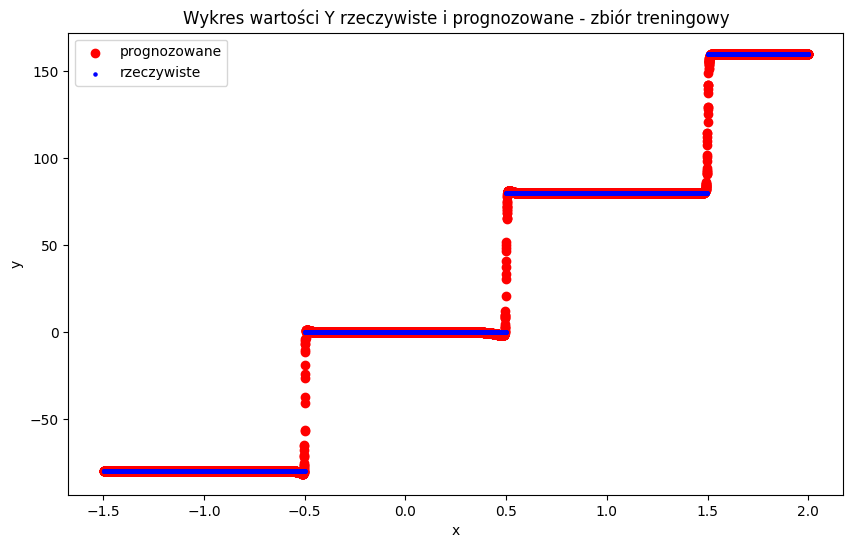

Train MSE =  3.499257868943841
 Test MSE =  3.438585268161009


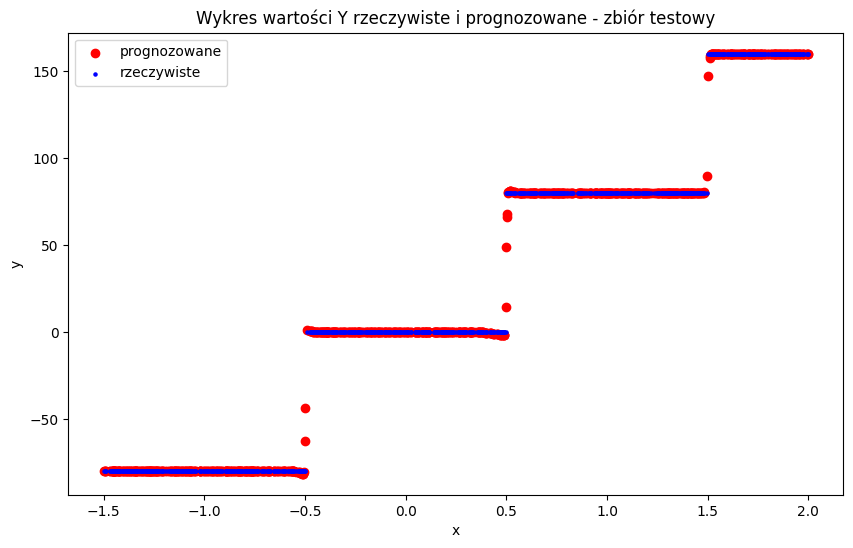

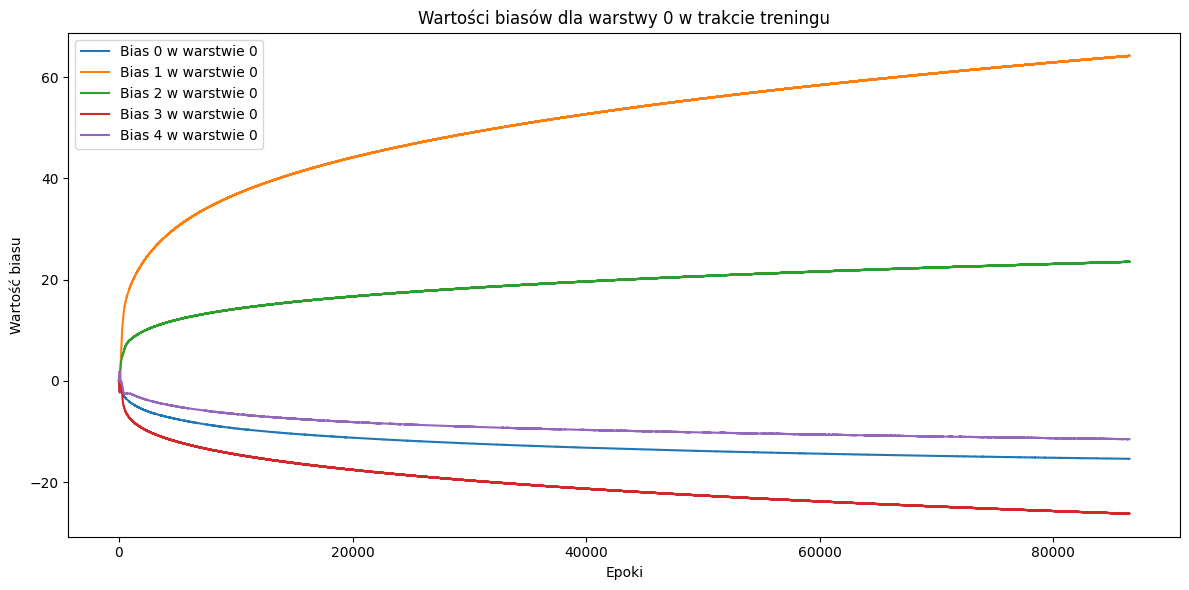

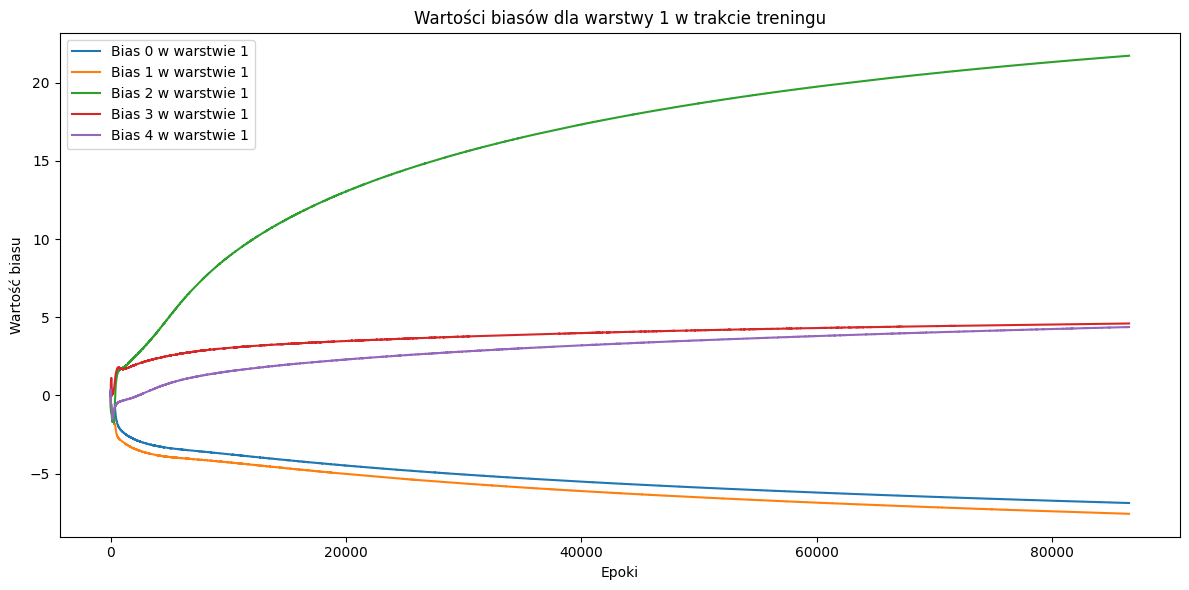

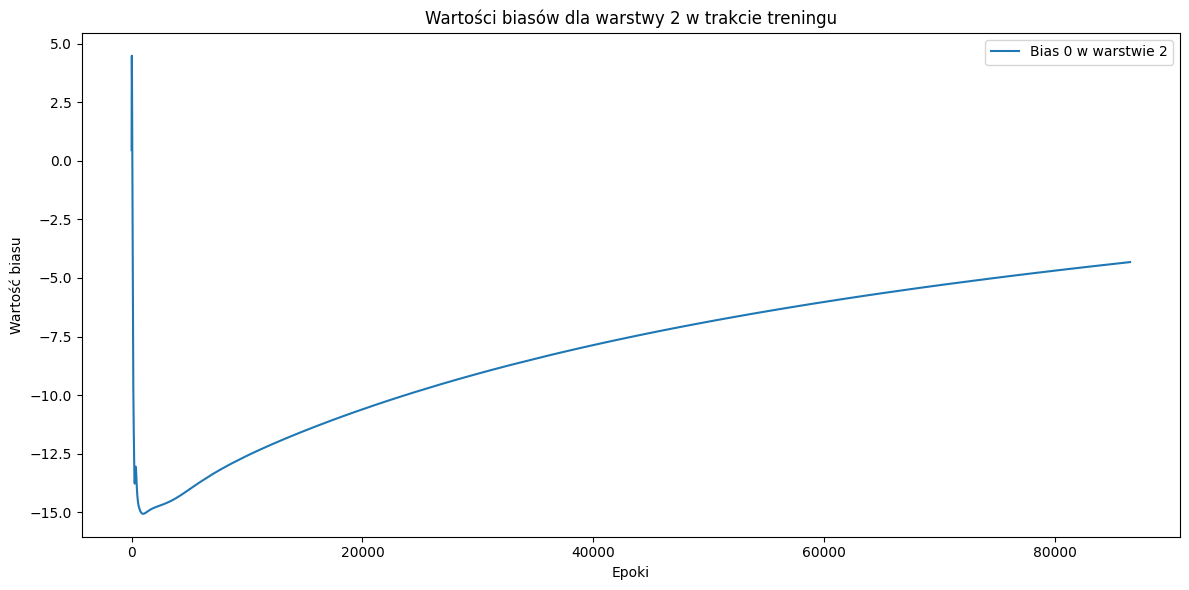

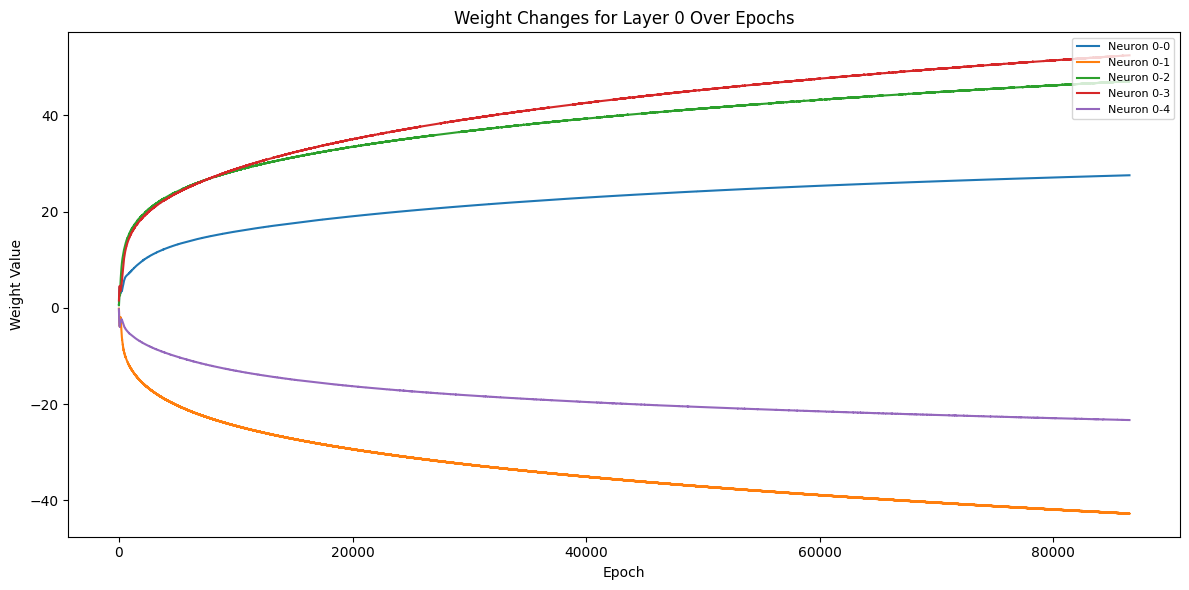

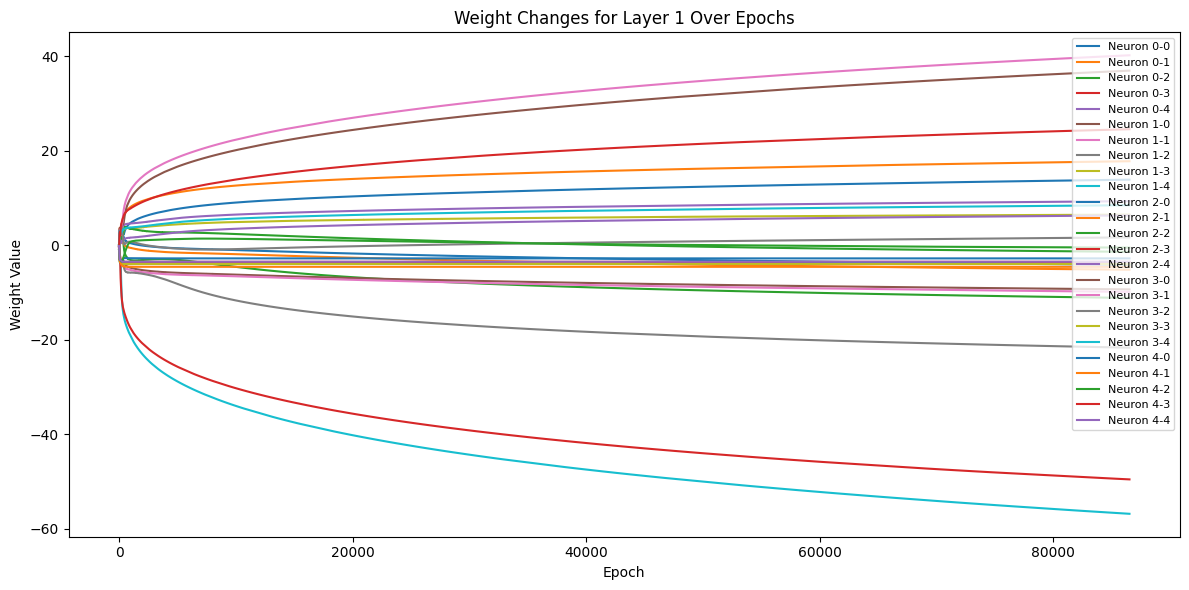

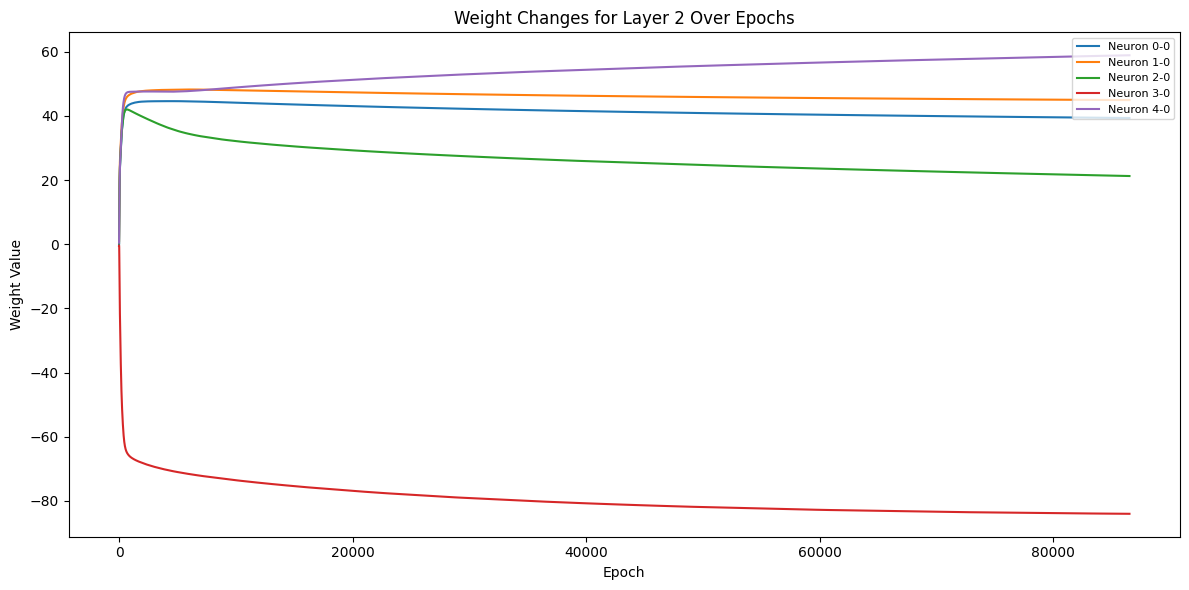

In [46]:
mlp = MLP([1, 5,5, 1])
df = pd.read_csv('mio1/regression/steps-large-training.csv', index_col=0)
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

mlp.fit_batch(X, y_true,500000, 0.000002, 3.5)


y_pred = mlp.predict(X)
mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

df = pd.read_csv('mio1/regression/steps-large-test.csv', index_col=0)
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
y_pred = mlp.predict(X_test)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


mlp.visualize_biases(0)
mlp.visualize_biases(1)
mlp.visualize_biases(2)
mlp.visualize_weights(0)
mlp.visualize_weights(1)
mlp.visualize_weights(2)

#### Różnica w tempie uczenia:
* całość - epoka:  251 541,  MSE =  3.4999911495661187
* batch -  epoka:   86 522,  MSE =  3.499257868943841

## 3. Zbiór square-simple

### Uczenie na całym zbiorze

Epoch 1/10000000, Loss: 10043.584665382634
Epoch 1001/10000000, Loss: 5654.568590811218
Epoch 2001/10000000, Loss: 4115.256250766582
Epoch 3001/10000000, Loss: 3363.4909101988965
Epoch 4001/10000000, Loss: 2975.1013106358996
Epoch 5001/10000000, Loss: 2744.586738978816
Epoch 6001/10000000, Loss: 2594.289887593882
Epoch 7001/10000000, Loss: 2494.8030883153633
Epoch 8001/10000000, Loss: 2428.020030423884
Epoch 9001/10000000, Loss: 2382.7546508091573
Epoch 10001/10000000, Loss: 2351.6656995735643
Epoch 11001/10000000, Loss: 2329.8403271539987
Epoch 12001/10000000, Loss: 2313.8508500259936
Epoch 13001/10000000, Loss: 2300.575502061316
Epoch 14001/10000000, Loss: 2268.866665670633
Epoch 15001/10000000, Loss: 1244.5338862359768
Epoch 16001/10000000, Loss: 1037.7723201773824
Epoch 17001/10000000, Loss: 895.5103552032244
Epoch 18001/10000000, Loss: 781.5772126937003
Epoch 19001/10000000, Loss: 688.360564003045
Epoch 20001/10000000, Loss: 611.0655143791416
Epoch 21001/10000000, Loss: 546.170511

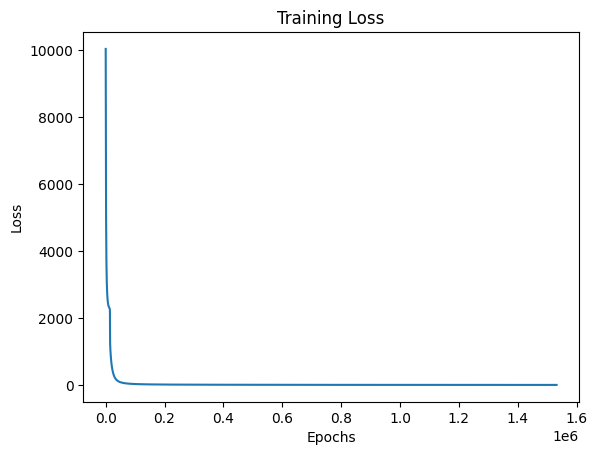

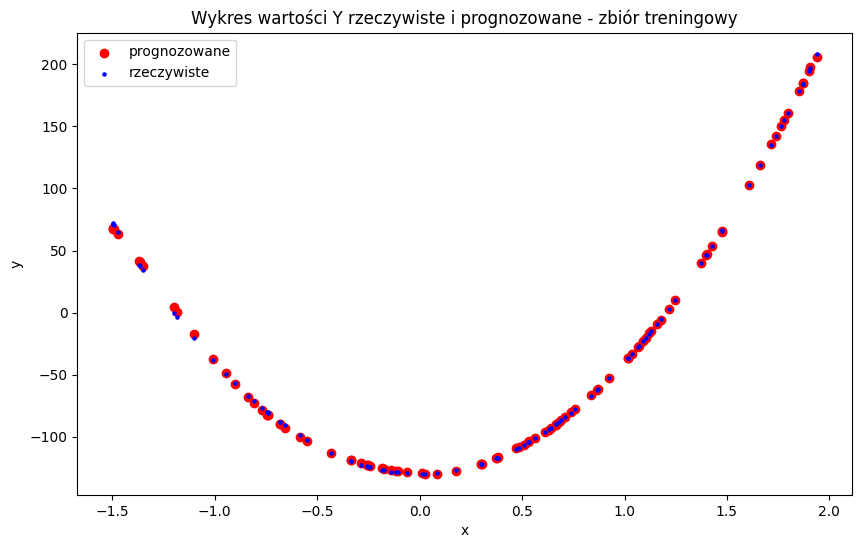

Train MSE =  1.9999993421270343
 Test MSE =  3.490026212822425


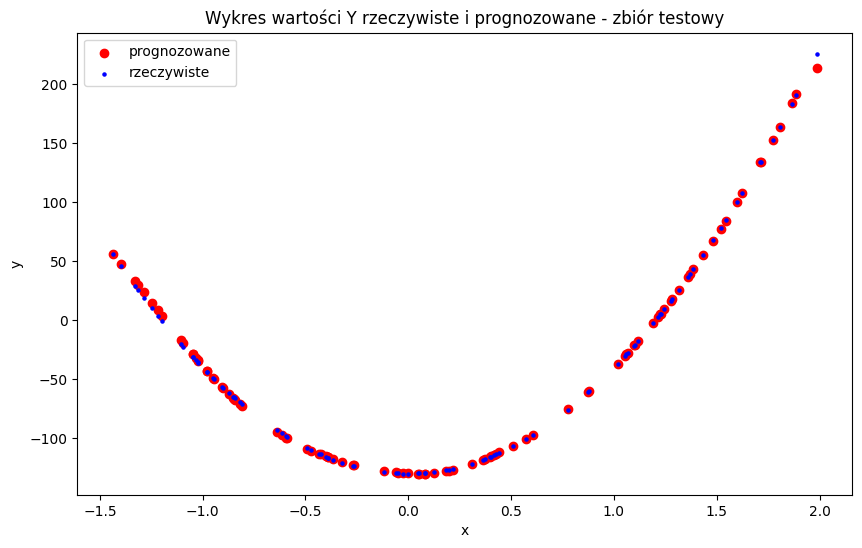

C:\Users\okroj\AppData\Local\Temp\ipykernel_19124\2762737853.py:175: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\okroj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


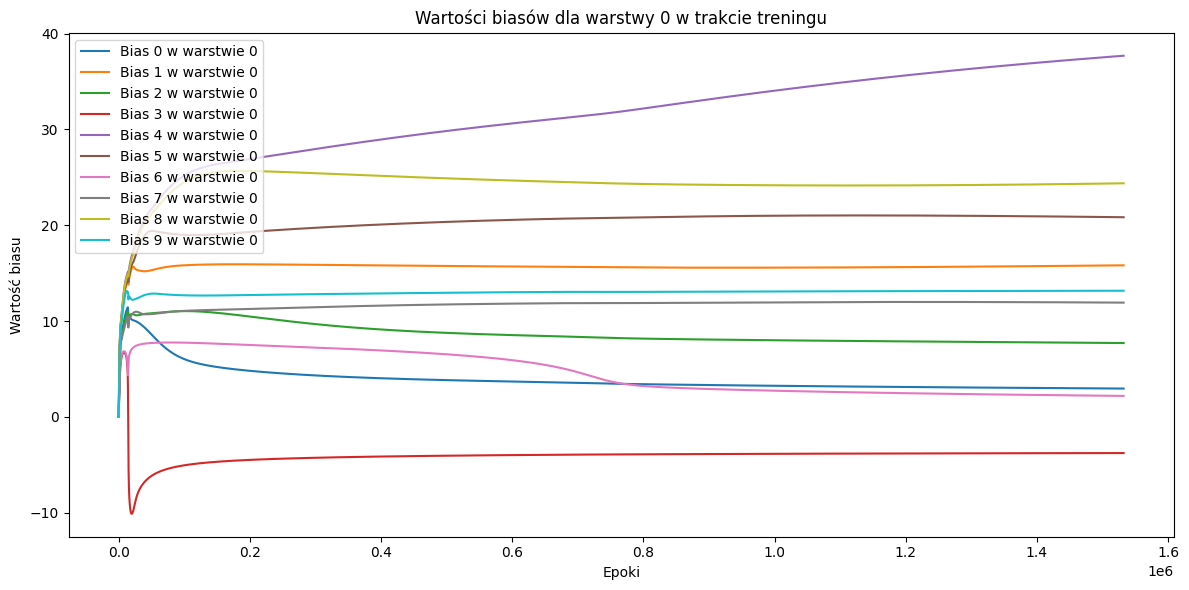

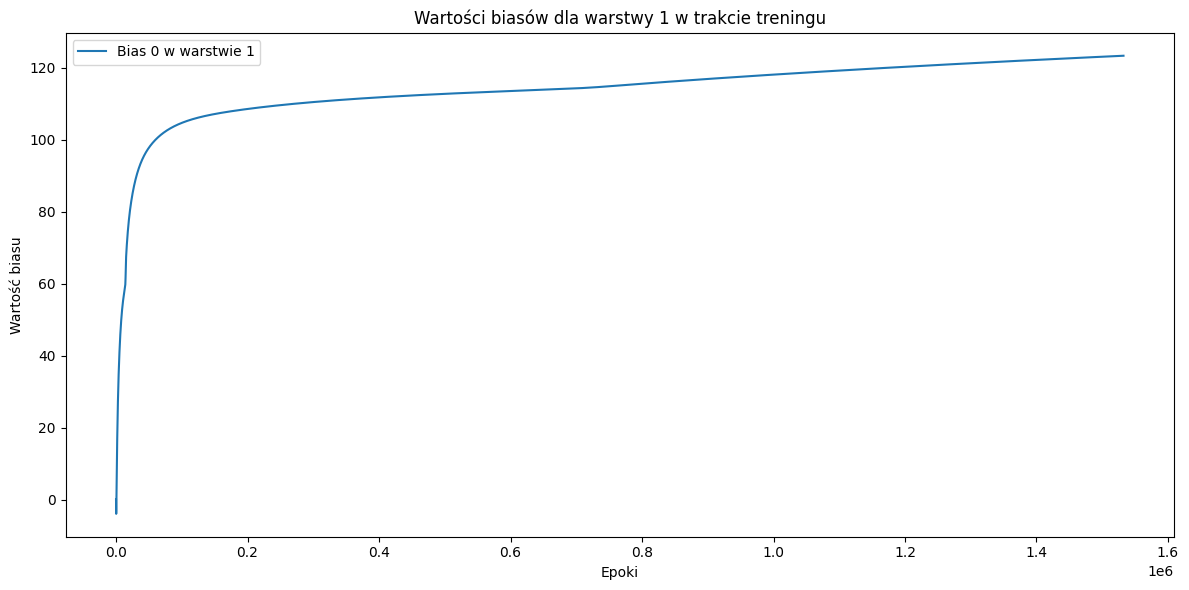

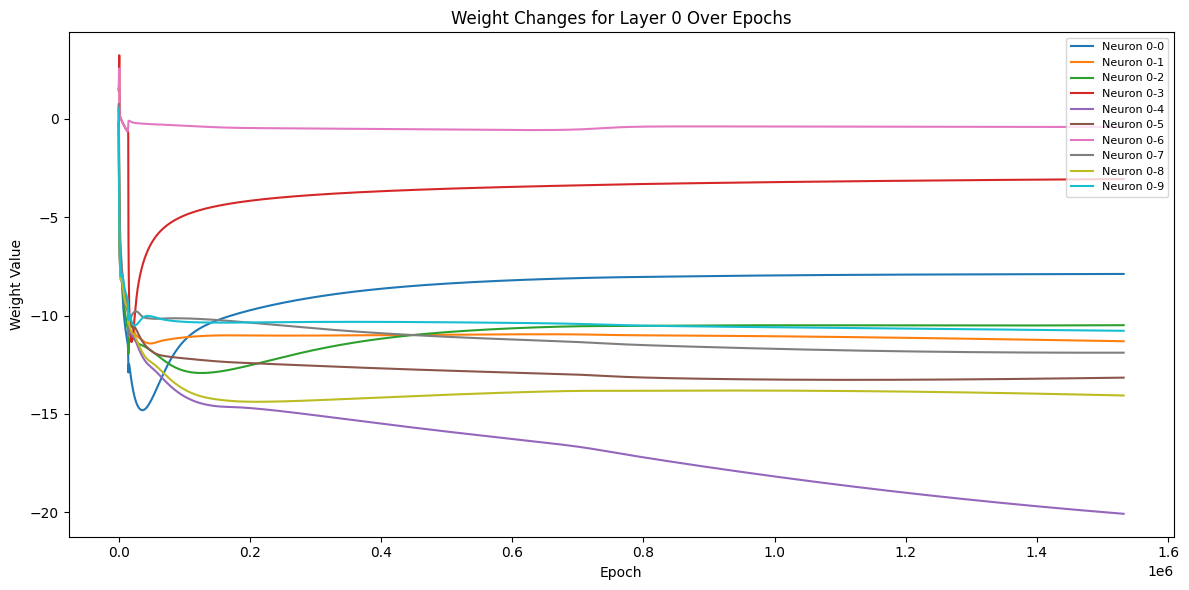

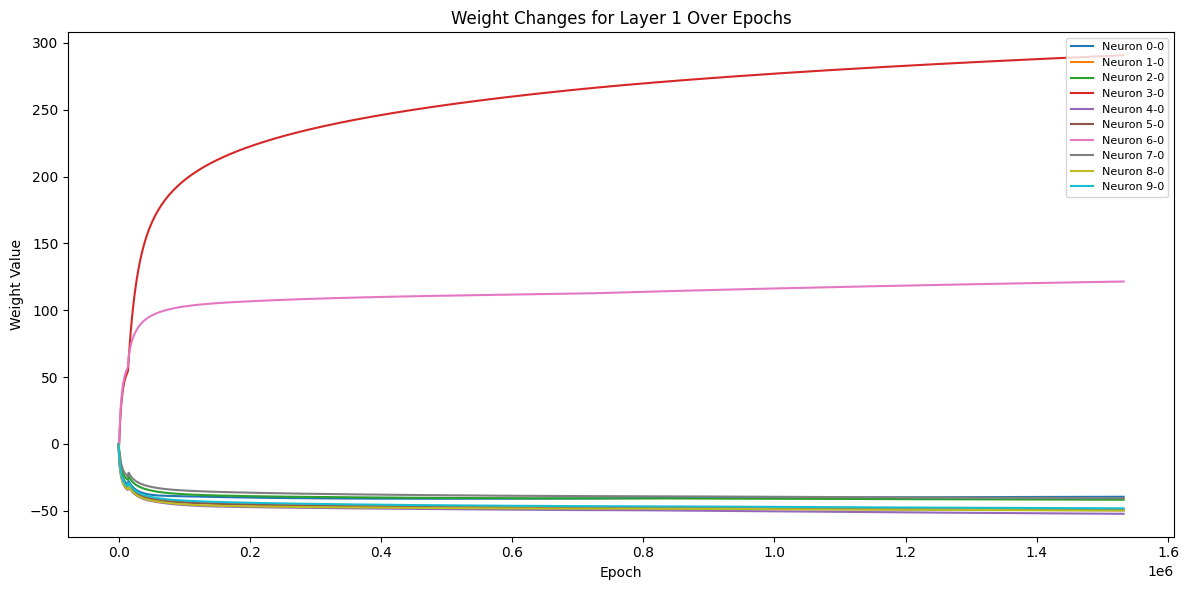

In [43]:
mlp = MLP([1, 10, 1])
df = pd.read_csv('mio1/regression/square-simple-training.csv', index_col=0)
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

mlp.fit(X, y_true,10000000, 0.00001, 2)

y_pred = mlp.predict(X)
mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

df = pd.read_csv('mio1/regression/square-simple-test.csv', index_col=0)
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
y_pred = mlp.predict(X_test)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

mlp.visualize_biases(0)
mlp.visualize_biases(1)
mlp.visualize_weights(0)
mlp.visualize_weights(1)


### Uczenie na kolejnych porcjach danych (batch)

Epoch 1000/10000000, Loss: 5653.036701248889
Epoch 2000/10000000, Loss: 4114.376357324225
Epoch 3000/10000000, Loss: 3363.0948514363245
Epoch 4000/10000000, Loss: 2974.9221095183575
Epoch 5000/10000000, Loss: 2744.4979745091755
Epoch 6000/10000000, Loss: 2594.2388773287685
Epoch 7000/10000000, Loss: 2494.7684986333475
Epoch 8000/10000000, Loss: 2427.994563481145
Epoch 9000/10000000, Loss: 2382.736066517719
Epoch 10000/10000000, Loss: 2351.6530625734317
Epoch 11000/10000000, Loss: 2329.833073676177
Epoch 12000/10000000, Loss: 2313.847984618517
Epoch 13000/10000000, Loss: 2300.578539108071
Epoch 14000/10000000, Loss: 2269.1245549362425
Epoch 15000/10000000, Loss: 1246.4995439572383
Epoch 16000/10000000, Loss: 1038.5878773994664
Epoch 17000/10000000, Loss: 896.1479398809511
Epoch 18000/10000000, Loss: 782.0975371677716
Epoch 19000/10000000, Loss: 688.7927446210904
Epoch 20000/10000000, Loss: 611.429407848117
Epoch 21000/10000000, Loss: 546.480758924876
Epoch 22000/10000000, Loss: 491.2576

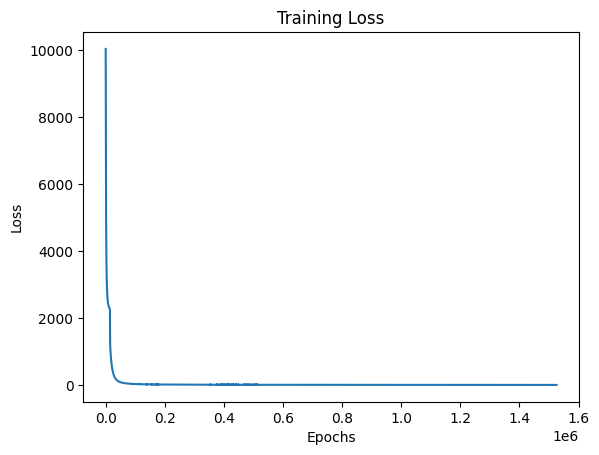

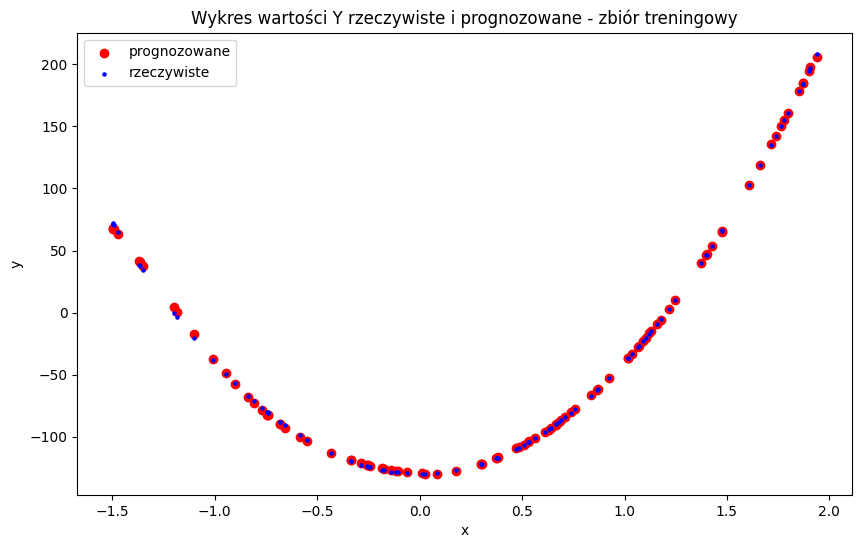

Train MSE =  1.999984768185455
 Test MSE =  3.4896112167725084


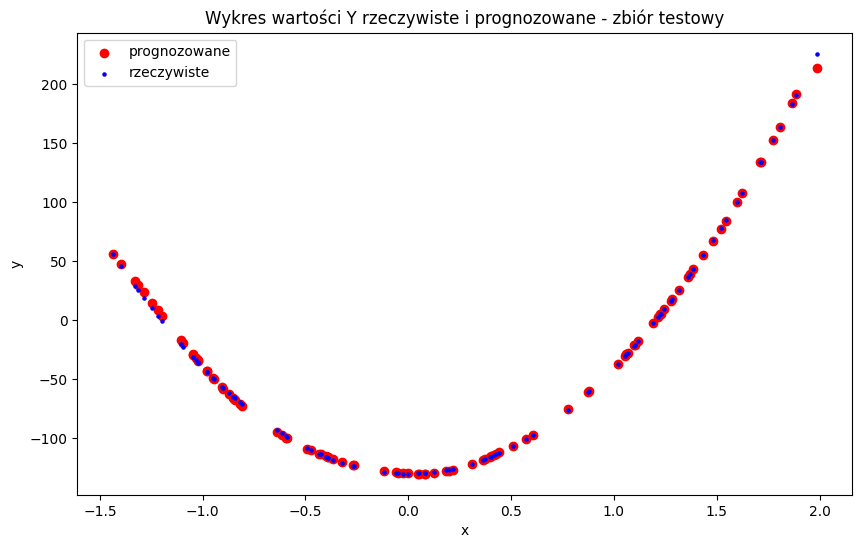

In [39]:
mlp = MLP([1, 10, 1])
df = pd.read_csv('mio1/regression/square-simple-training.csv', index_col=0)
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

mlp.fit_batch(X, y_true,10000000, 0.00001, 2)

y_pred = mlp.predict(X)
mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

df = pd.read_csv('mio1/regression/square-simple-test.csv', index_col=0)
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
y_pred = mlp.predict(X_test)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

C:\Users\okroj\AppData\Local\Temp\ipykernel_19124\2762737853.py:175: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\okroj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


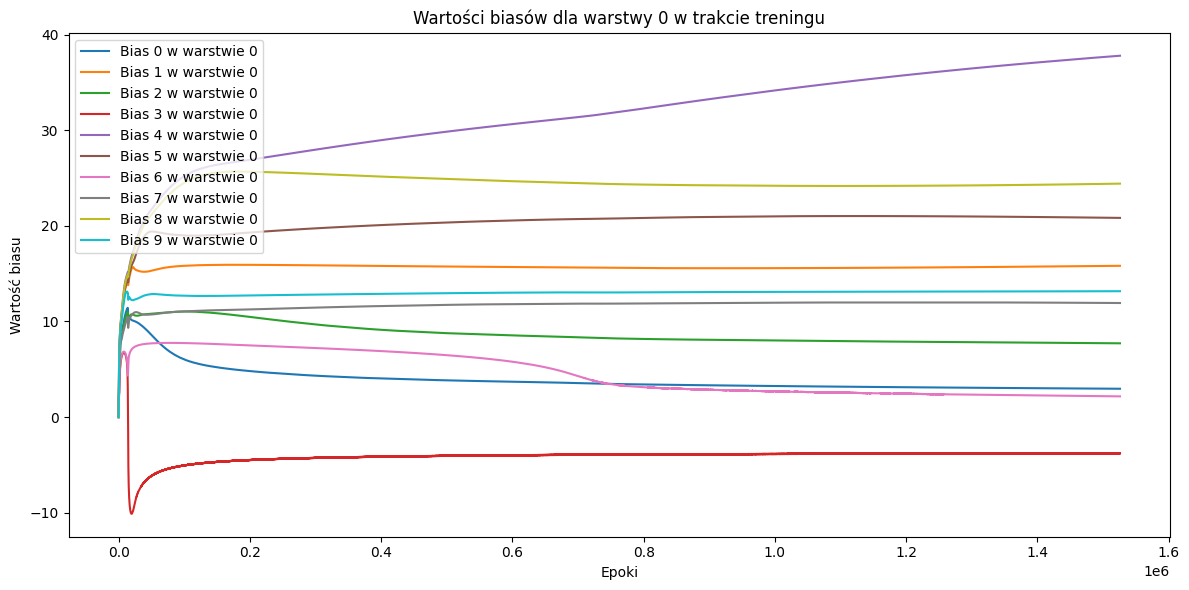

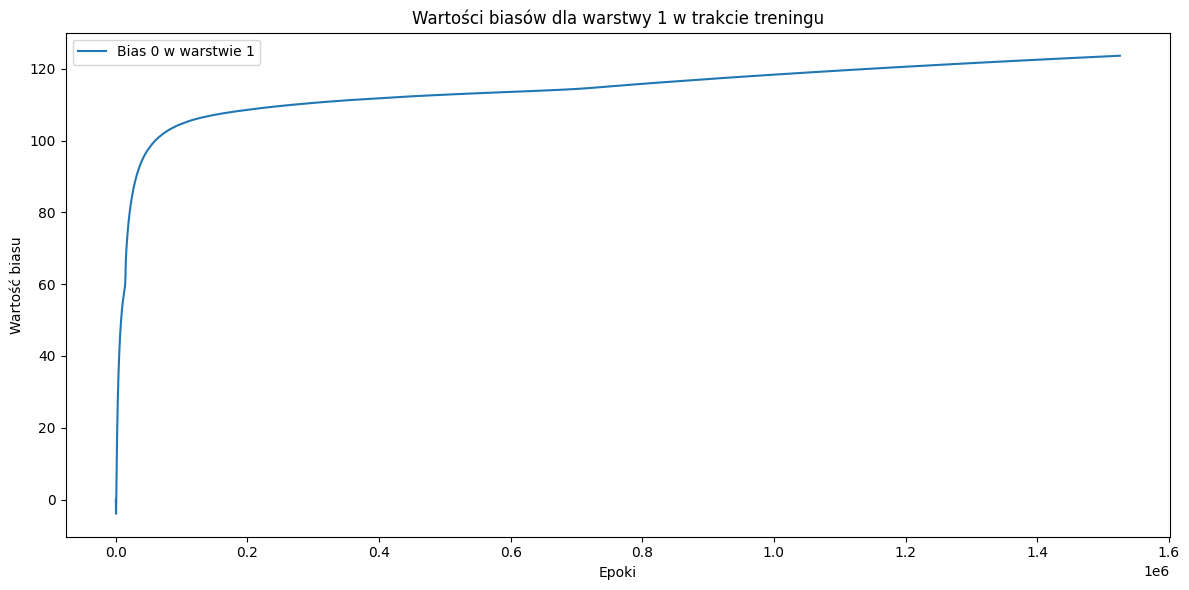

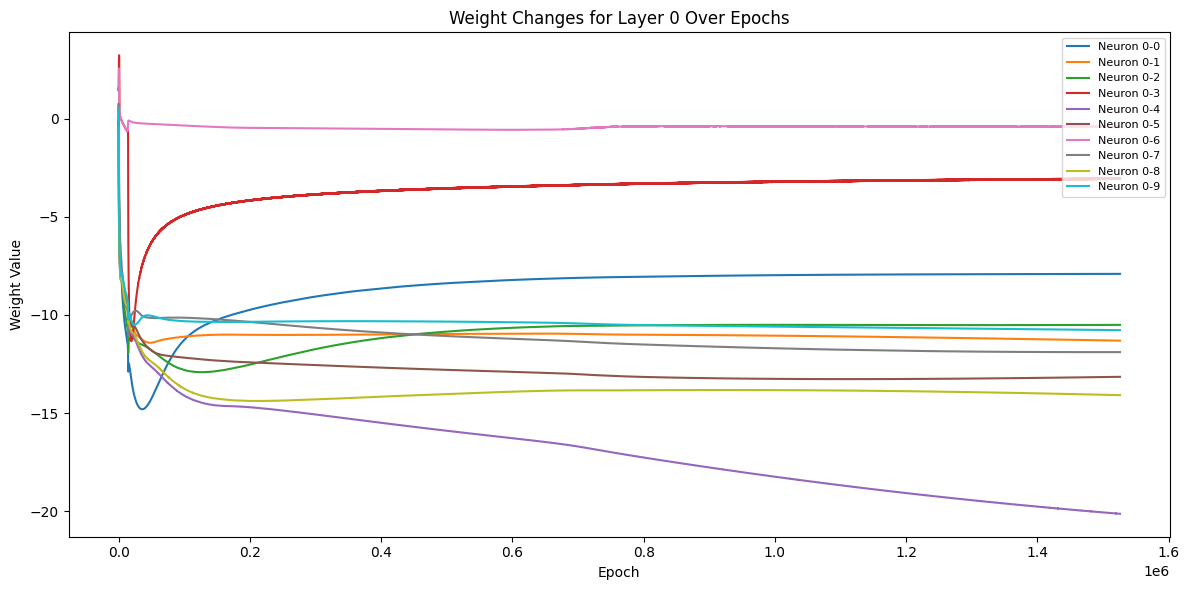

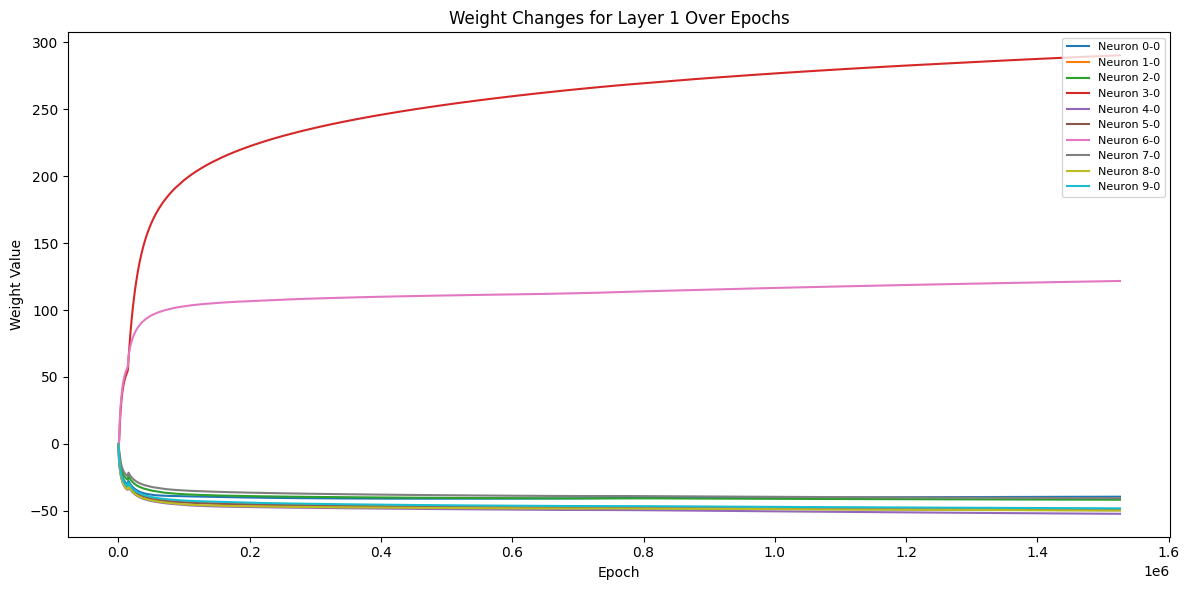

In [40]:
mlp.visualize_biases(0)
mlp.visualize_biases(1)
mlp.visualize_weights(0)
mlp.visualize_weights(1)

#### Różnica w tempie uczenia:
* całość - epoka:  1 532 330, MSE =  1.9999993421270343
* batch -  epoka:  1 525 749, MSE =  1.999984768185455

## 4. Zbiór multimodal-large

### Uczenie na całym zbiorze

Epoch 1/10000, Loss: 5377.81981061407
Epoch 1001/10000, Loss: 763.6003559496529
Epoch 2001/10000, Loss: 623.1064551830102
Epoch 3001/10000, Loss: 587.4397294519281
Epoch 4001/10000, Loss: 580.4203719459585
Epoch 5001/10000, Loss: 579.8884043134922
finished_early on epoch:  5850 , with MSE =  39.88061412267879


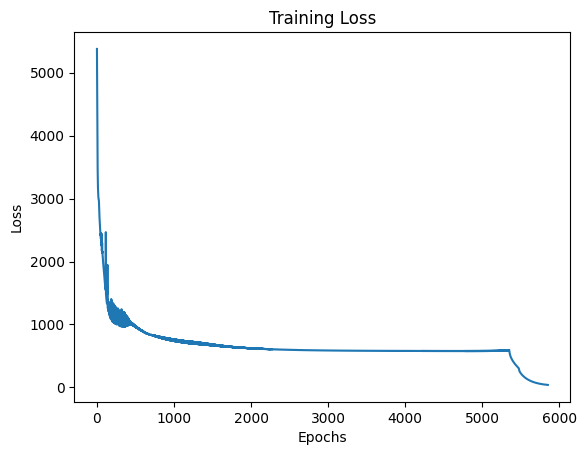

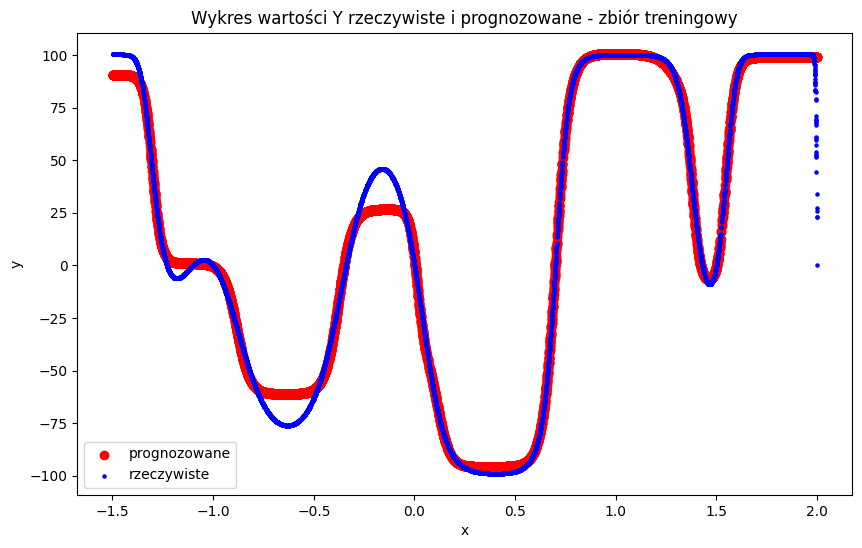

Train MSE =  39.88061412267879
 Test MSE =  34.976109088464376


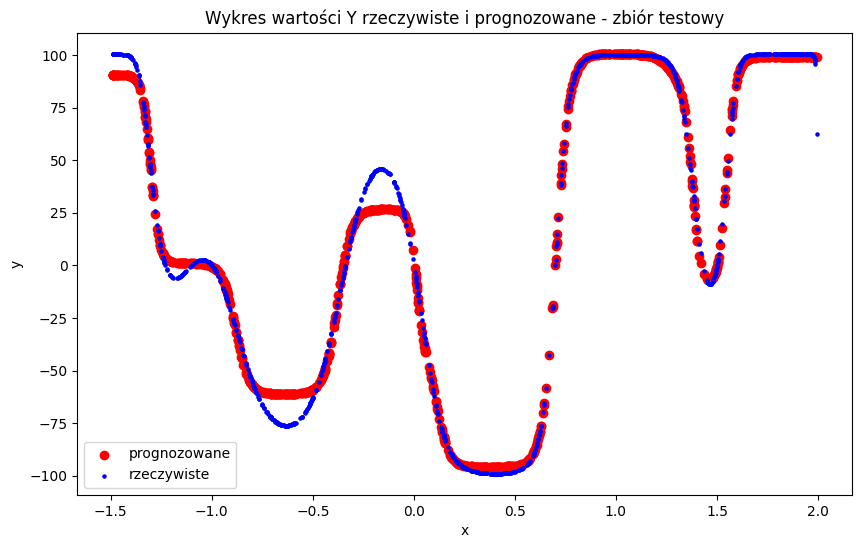

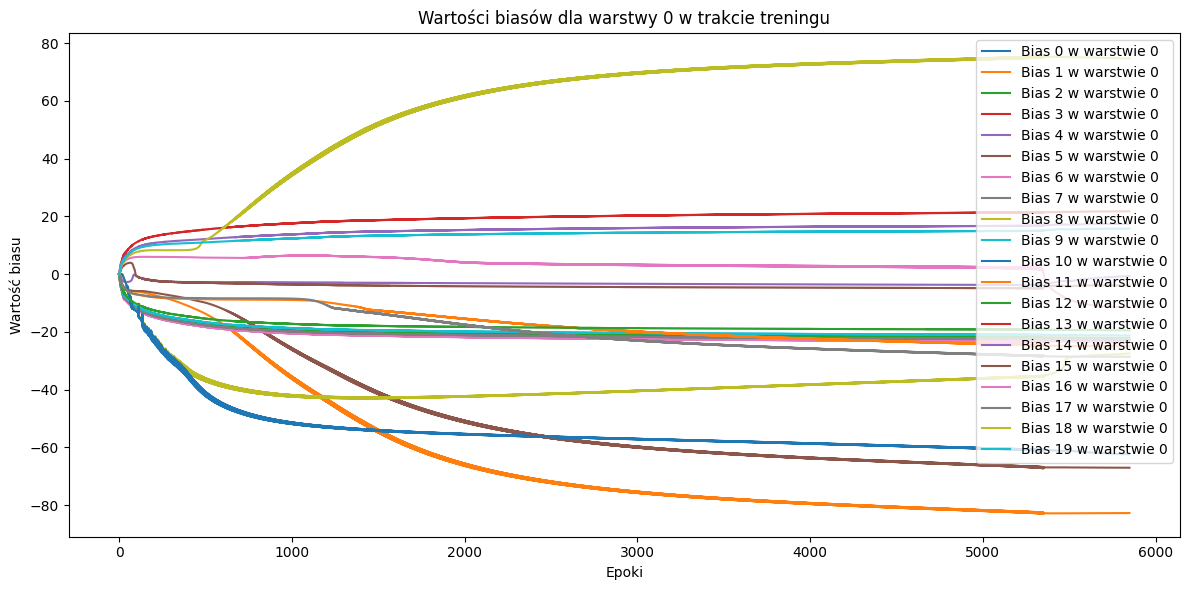

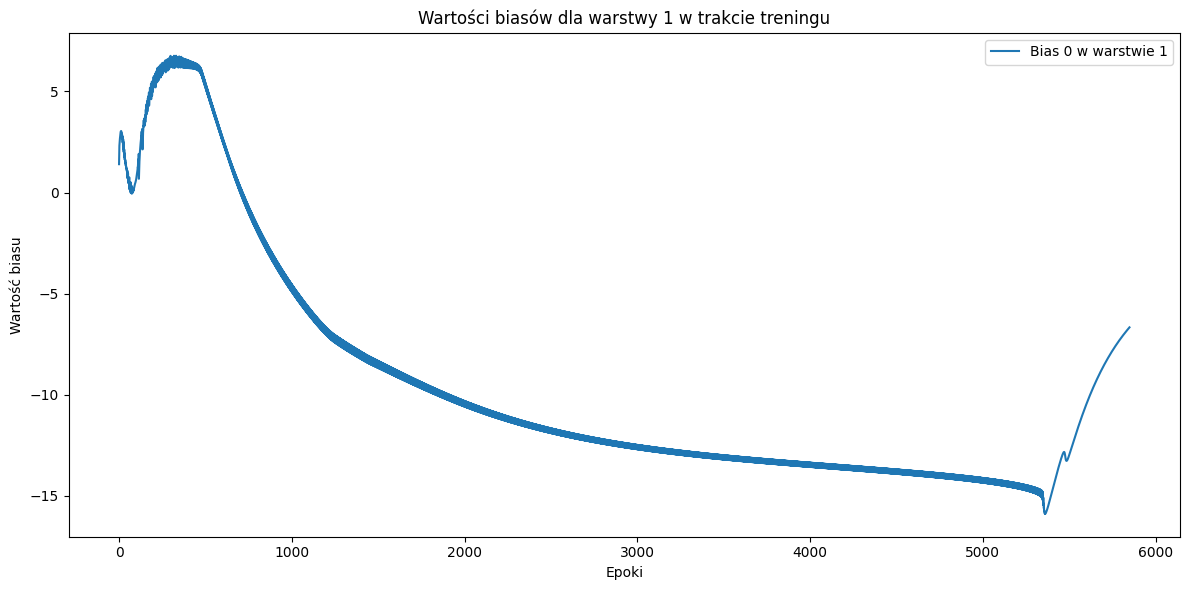

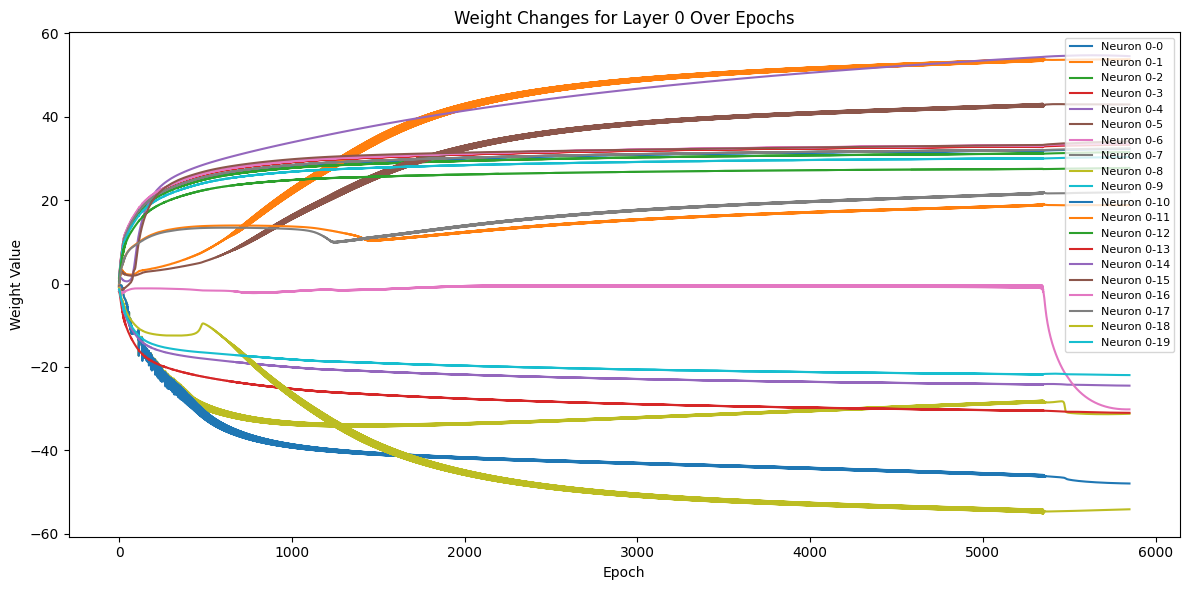

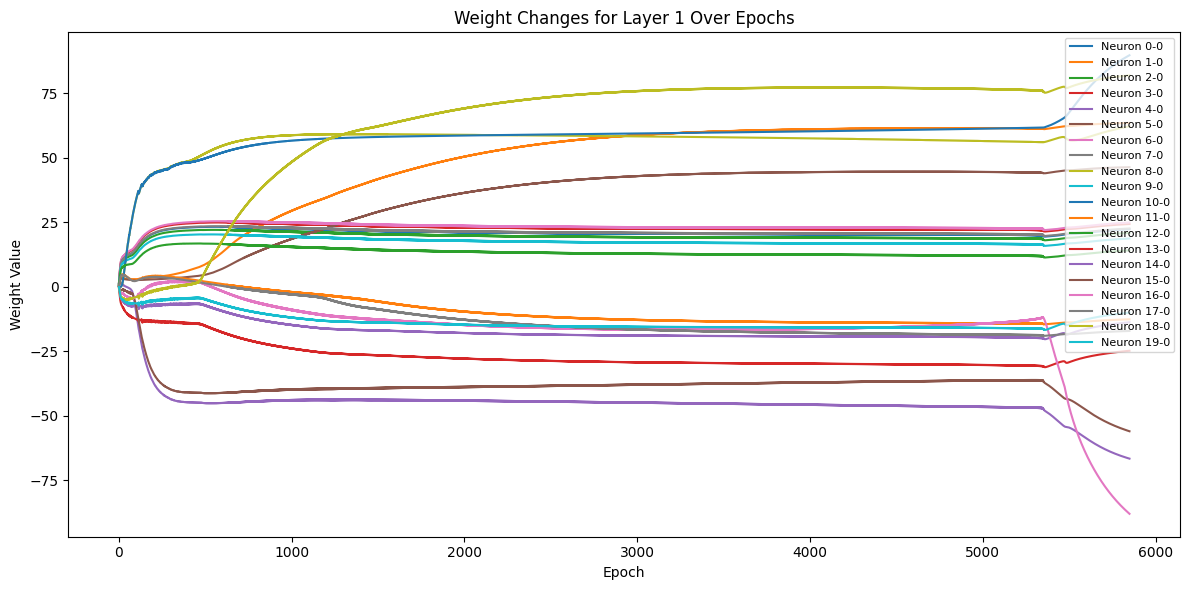

In [41]:
mlp = MLP([1, 20, 1])
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

mlp.fit(X, y_true,10000, 0.00001, 40)

y_pred = mlp.predict(X)
mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
y_pred = mlp.predict(X_test)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

mlp.visualize_biases(0)
mlp.visualize_biases(1)
mlp.visualize_weights(0)
mlp.visualize_weights(1)


### Uczenie na kolejnych porcjach danych (batch)

Epoch 1000/10000, Loss: 716.2448485786597
finished_early on epoch:  1916 , with MSE =  39.99292167725086


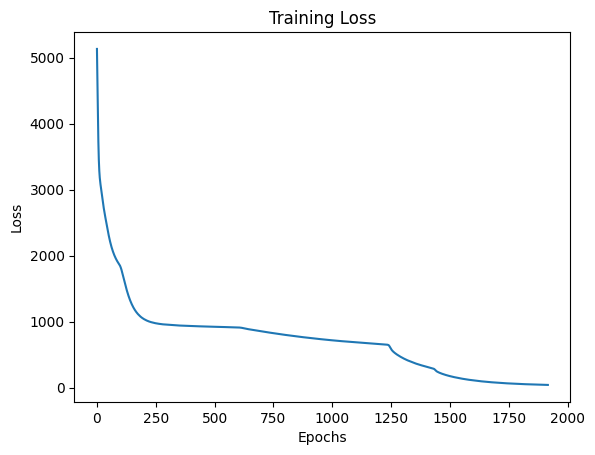

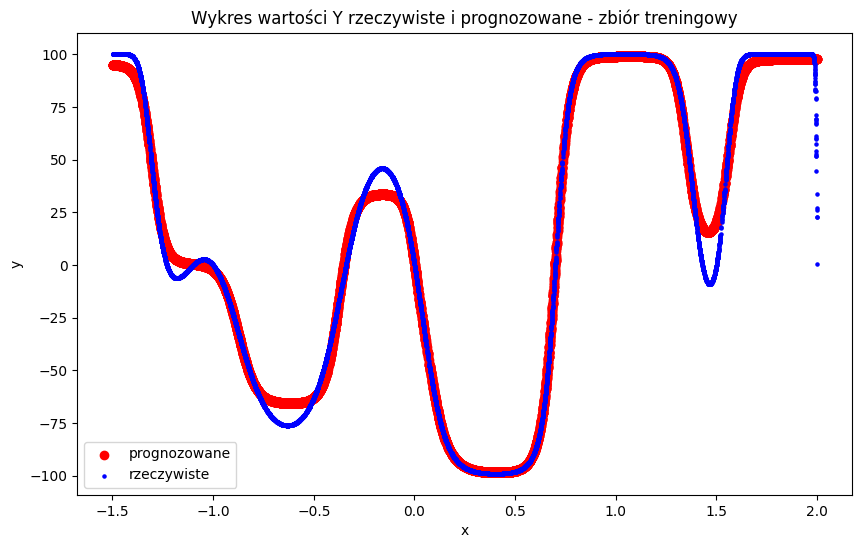

Train MSE =  39.99292167725086
 Test MSE =  39.361787485044395


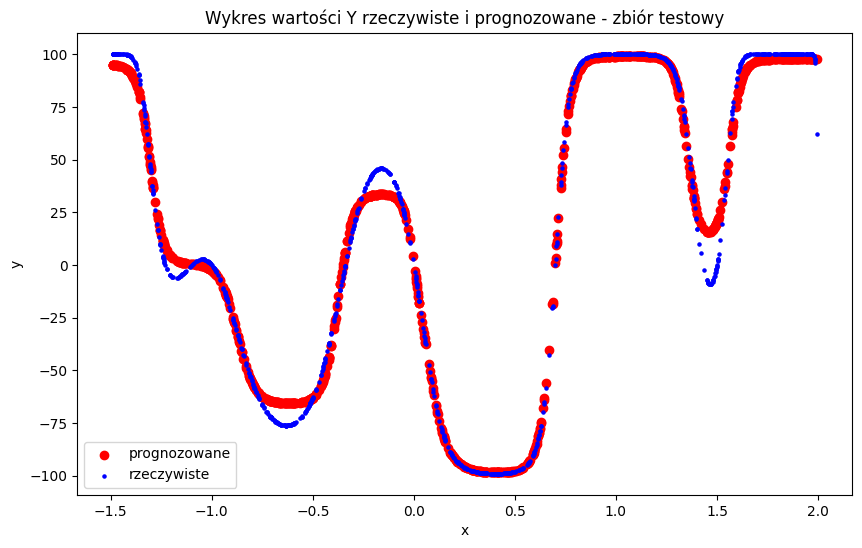

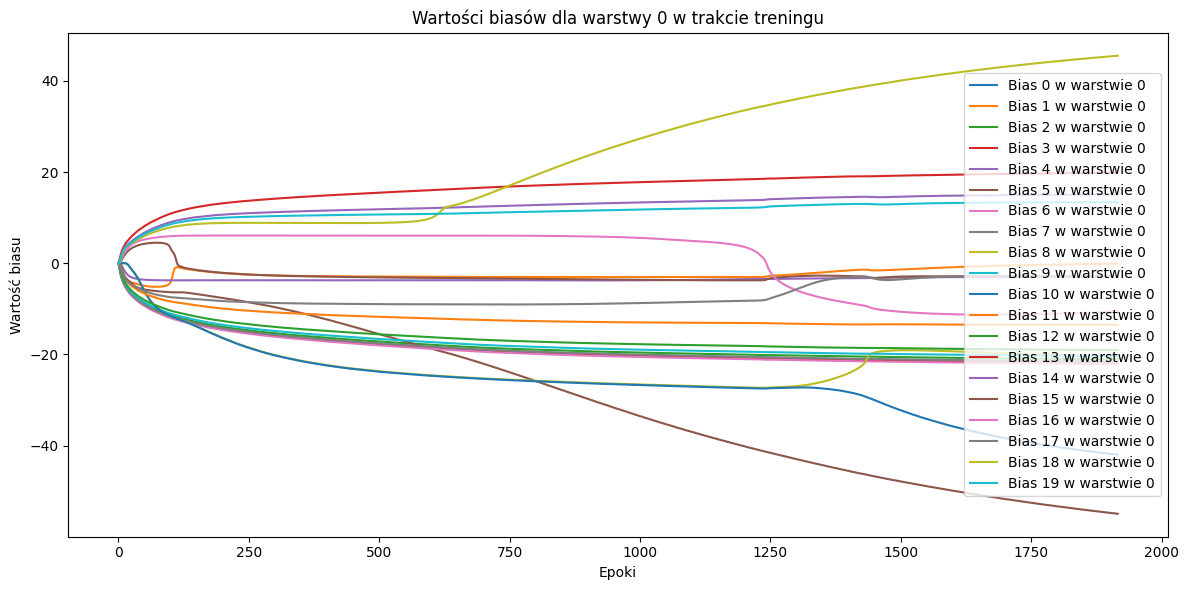

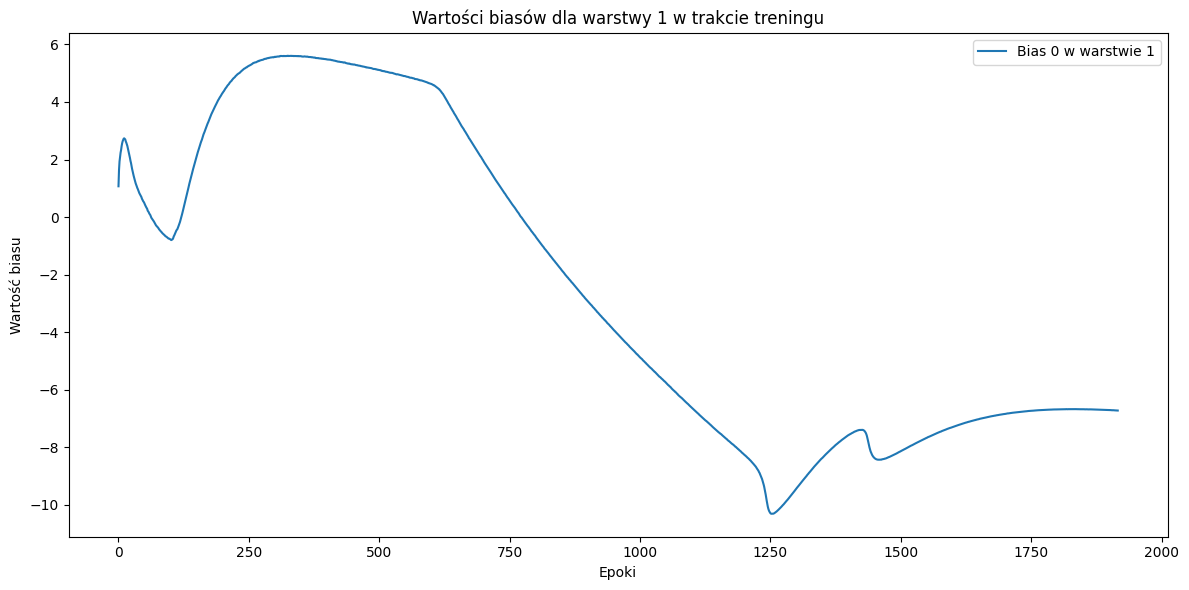

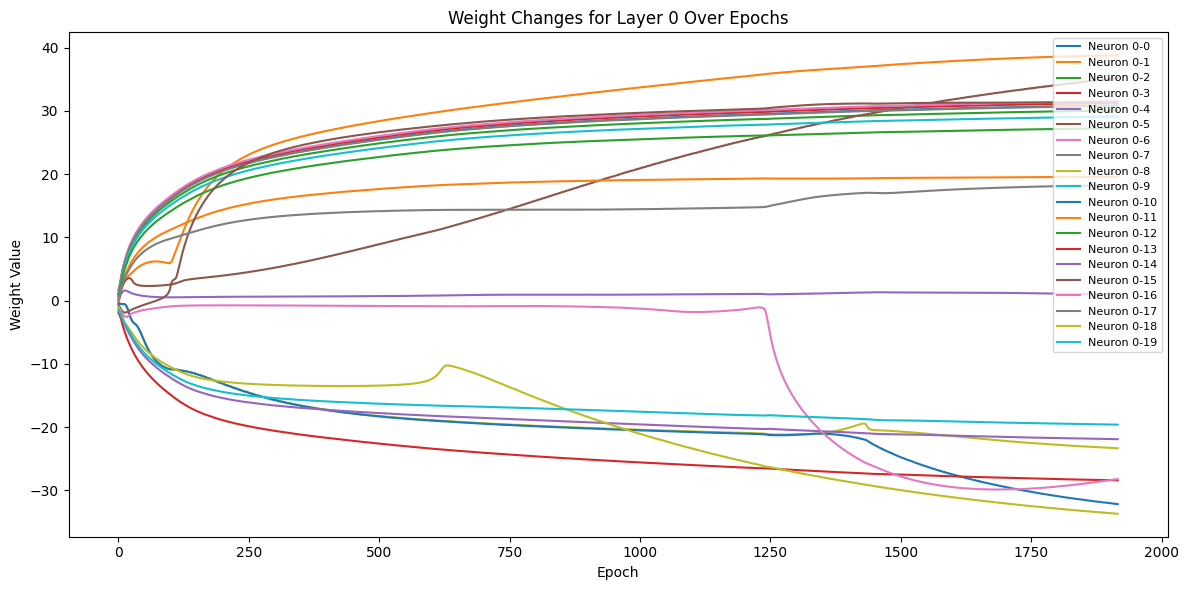

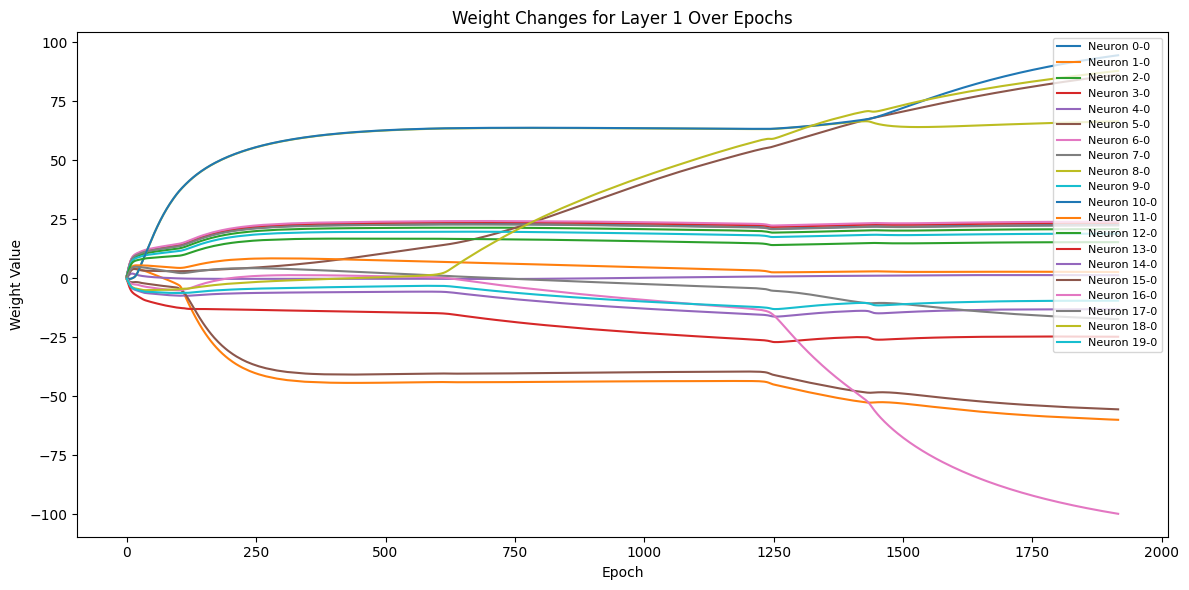

In [42]:
mlp = MLP([1, 20, 1])
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

mlp.fit_batch(X, y_true,10000, 0.00001, 40)

y_pred = mlp.predict(X)
mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
y_pred = mlp.predict(X_test)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

mlp.visualize_biases(0)
mlp.visualize_biases(1)
mlp.visualize_weights(0)
mlp.visualize_weights(1)


#### Różnica w tempie uczenia:
* całość - epoka:  5 850, MSE =  39.88061412267879
* batch -  epoka:  1 916, MSE =  39.99292167725086